# What factors determine the success or popularity of a business?
In this notebook we are going to see how we could make sure our dream business venture succeed despite neighboring competition all around. There will be a lot of factors to take into account such as the kind of food we serve, our location , and even the cost of our products. Until now we haven't decided what kind of business to create but rather we're just looking to analyze the market on a cursory level in this notebook and in subsequent ones we plan on going further in depth with regressions including multiple independent variables , time-series analysis, etc.

To begin we'll import some needed libraries

In [1]:
from google.oauth2 import service_account
from google.cloud import bigquery
import configparser
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

Now we'll be setting up authentication to connect to our data warehouse in Google Big Query

In [2]:
KEY_PATH = "/mnt/c/Users/Ron/git-repos/yelp-data/gourmanddwh-f75384f95e86.json"
CREDS = service_account.Credentials.from_service_account_file(KEY_PATH)
client = bigquery.Client(credentials=CREDS, project=CREDS.project_id)

Using the bigquery API we can use select statements to place the results in pandas dataframes so we'll do so for a couple of queries


In [3]:
cg_file = open('sql_scripts/county_growth_est.sql','r')
county_growth_query =  cg_file.read()
cg_dataframe = (
    client.query(county_growth_query)
    .result()
    .to_dataframe()
)

In [4]:
holding_file = open('sql_scripts/business_daily_holding.sql')
holding_query = holding_file.read()

holding_dataframe = (
    client.query(holding_query)
    .result()
    .to_dataframe()
)

In [5]:
bus_cat_file = open('sql_scripts/business_category_location.sql')
bus_cat_query = bus_cat_file.read()

bus_cat_dataframe = (
    client.query(bus_cat_query)
    .result()
    .to_dataframe()
)

explain differences from previous year

In [14]:
cg_dataframe

StateName       CountyName  EstimationYear  EstimatedPopulation  \
0       California  Siskiyou County            2019                43539   
1         Colorado  Saguache County            2019                 6824   
2          Indiana   Madison County            2019               129569   
3           Kansas  Franklin County            2019                25544   
4         Kentucky     Green County            2019                10941   
...            ...              ...             ...                  ...   
3215  South Dakota     Jones County            2019                  903   
3216     Tennessee  Hardeman County            2019                25050   
3217         Texas    Scurry County            2019                16703   
3218     Wisconsin    Pierce County            2019                42754   
3219       Wyoming   Lincoln County            2019                19830   

      lastpop  relative_delta  abs_delta  
0       43550           -0.00        -11  
1        6840           -0.00        -16  
2      129573           -0.00         -4  
3       25625           -0.00        -81  
4       10998           -0.01        -57  
...       ...             ...        ...  
3215      928           -0.03        -25  
3216    25276           -0.01       -226  
3217    16812           -0.01       -109  
3218    42592            0.00        162  
3219    19445            0.02        385  

[3220 rows x 7 columns]

Making slight changes on the data types

In [15]:
holding_dataframe

BusinessName             ChainName BusinessRating  \
0         1-chinese-restaurant-coinjock  1 Chinese Restaurant    3.000000000   
1         1-chinese-restaurant-coinjock  1 Chinese Restaurant    3.000000000   
2         1-chinese-restaurant-coinjock  1 Chinese Restaurant    3.000000000   
3         1-chinese-restaurant-coinjock  1 Chinese Restaurant    3.000000000   
4         1-chinese-restaurant-coinjock  1 Chinese Restaurant    3.000000000   
...                                 ...                   ...            ...   
510424  él-torito-restaurant-georgetown  Él Torito Restaurant    4.000000000   
510425  él-torito-restaurant-georgetown  Él Torito Restaurant    4.000000000   
510426  él-torito-restaurant-georgetown  Él Torito Restaurant    4.000000000   
510427  él-torito-restaurant-georgetown  Él Torito Restaurant    4.000000000   
510428  él-torito-restaurant-georgetown  Él Torito Restaurant    4.000000000   

        ReviewCount  CloseDate  previous_review_cnt previous_rating  \
0                 2 2021-12-29                  NaN            None   
1                 2 2022-01-07                 2.00     3.000000000   
2                 2 2022-01-08                 2.00     3.000000000   
3                 2 2022-01-09                 2.00     3.000000000   
4                 2 2022-01-10                 2.00     3.000000000   
...             ...        ...                  ...             ...   
510424            2 2022-01-09                 2.00     4.000000000   
510425            2 2022-01-10                 2.00     4.000000000   
510426            2 2022-01-11                 2.00     4.000000000   
510427            2 2022-01-12                 2.00     4.000000000   
510428            2 2022-01-13                 2.00     4.000000000   

        abs_review_diff abs_rating_diff  total_review_cnt_delta  \
0                   NaN            None                    0.00   
1                  0.00            0E-9                    0.00   
2                  0.00            0E-9                    0.00   
3                  0.00            0E-9                    0.00   
4                  0.00            0E-9                    0.00   
...                 ...             ...                     ...   
510424             0.00            0E-9                    0.00   
510425             0.00            0E-9                    0.00   
510426             0.00            0E-9                    0.00   
510427             0.00            0E-9                    0.00   
510428             0.00            0E-9                    0.00   

       total_bus_rating_delta  
0                        0E-9  
1                        0E-9  
2                        0E-9  
3                        0E-9  
4                        0E-9  
...                       ...  
510424                   0E-9  
510425                   0E-9  
510426                   0E-9  
510427                   0E-9  
510428                   0E-9  

[510429 rows x 11 columns]

In [16]:
holding_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510429 entries, 0 to 510428
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   BusinessName            510429 non-null  object        
 1   ChainName               510429 non-null  object        
 2   BusinessRating          510429 non-null  object        
 3   ReviewCount             510429 non-null  int64         
 4   CloseDate               510429 non-null  datetime64[ns]
 5   previous_review_cnt     447112 non-null  float64       
 6   previous_rating         447112 non-null  object        
 7   abs_review_diff         447112 non-null  float64       
 8   abs_rating_diff         447112 non-null  object        
 9   total_review_cnt_delta  509680 non-null  float64       
 10  total_bus_rating_delta  509680 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 42.8+ MB


In [19]:
holding_dataframe['CloseDate'] = pd.to_datetime(holding_dataframe['CloseDate'])
holding_dataframe[['BusinessRating', 'previous_rating', 'abs_rating_diff', 'total_bus_rating_delta']] = holding_dataframe[['BusinessRating', 'previous_rating', 'abs_rating_diff', 'total_bus_rating_delta']].astype(float)

In [20]:
holding_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510429 entries, 0 to 510428
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   BusinessName            510429 non-null  object        
 1   ChainName               510429 non-null  object        
 2   BusinessRating          510429 non-null  float64       
 3   ReviewCount             510429 non-null  int64         
 4   CloseDate               510429 non-null  datetime64[ns]
 5   previous_review_cnt     447112 non-null  float64       
 6   previous_rating         447112 non-null  float64       
 7   abs_review_diff         447112 non-null  float64       
 8   abs_rating_diff         447112 non-null  float64       
 9   total_review_cnt_delta  509680 non-null  float64       
 10  total_bus_rating_delta  509680 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 42.8+ MB


In [21]:
holding_dataframe

BusinessName             ChainName  BusinessRating  \
0         1-chinese-restaurant-coinjock  1 Chinese Restaurant            3.00   
1         1-chinese-restaurant-coinjock  1 Chinese Restaurant            3.00   
2         1-chinese-restaurant-coinjock  1 Chinese Restaurant            3.00   
3         1-chinese-restaurant-coinjock  1 Chinese Restaurant            3.00   
4         1-chinese-restaurant-coinjock  1 Chinese Restaurant            3.00   
...                                 ...                   ...             ...   
510424  él-torito-restaurant-georgetown  Él Torito Restaurant            4.00   
510425  él-torito-restaurant-georgetown  Él Torito Restaurant            4.00   
510426  él-torito-restaurant-georgetown  Él Torito Restaurant            4.00   
510427  él-torito-restaurant-georgetown  Él Torito Restaurant            4.00   
510428  él-torito-restaurant-georgetown  Él Torito Restaurant            4.00   

        ReviewCount  CloseDate  previous_review_cnt  previous_rating  \
0                 2 2021-12-29                  NaN              NaN   
1                 2 2022-01-07                 2.00             3.00   
2                 2 2022-01-08                 2.00             3.00   
3                 2 2022-01-09                 2.00             3.00   
4                 2 2022-01-10                 2.00             3.00   
...             ...        ...                  ...              ...   
510424            2 2022-01-09                 2.00             4.00   
510425            2 2022-01-10                 2.00             4.00   
510426            2 2022-01-11                 2.00             4.00   
510427            2 2022-01-12                 2.00             4.00   
510428            2 2022-01-13                 2.00             4.00   

        abs_review_diff  abs_rating_diff  total_review_cnt_delta  \
0                   NaN              NaN                    0.00   
1                  0.00             0.00                    0.00   
2                  0.00             0.00                    0.00   
3                  0.00             0.00                    0.00   
4                  0.00             0.00                    0.00   
...                 ...              ...                     ...   
510424             0.00             0.00                    0.00   
510425             0.00             0.00                    0.00   
510426             0.00             0.00                    0.00   
510427             0.00             0.00                    0.00   
510428             0.00             0.00                    0.00   

        total_bus_rating_delta  
0                         0.00  
1                         0.00  
2                         0.00  
3                         0.00  
4                         0.00  
...                        ...  
510424                    0.00  
510425                    0.00  
510426                    0.00  
510427                    0.00  
510428                    0.00  

[510429 rows x 11 columns]

In [9]:
bus_cat_dataframe

BusinessKey                             BusinessName  \
0                23         eastern-shore-street-eats-daphne   
1                23         eastern-shore-street-eats-daphne   
2                33              chris-hot-dogs-montgomery-2   
3               122  benjas-thai-and-sushi-restaurant-mobile   
4               122  benjas-thai-and-sushi-restaurant-mobile   
...             ...                                      ...   
126522        62893                        munchies-evanston   
126523        63106       don-juan-mexican-restaurant-casper   
126524        63128        the-hangar-bar-and-grill-bar-nunn   
126525        63155                 wyoming-hot-wings-casper   
126526        63221  rendezvous-meadows-golf-course-pinedale   

                              ChainName PaymentLevelName       Longitude  \
0             Eastern Shore Street Eats          Unknown   -87.868675000   
1             Eastern Shore Street Eats          Unknown   -87.868675000   
2                       Chris' Hot Dogs         Very Low   -86.306631000   
3       Benja's Thai & Sushi Restaurant              Low   -88.190163000   
4       Benja's Thai & Sushi Restaurant              Low   -88.190163000   
...                                 ...              ...             ...   
126522                         Munchies          Unknown  -110.965810000   
126523      Don Juan Mexican Restaurant         Very Low  -106.325400000   
126524         The Hangar Bar And Grill              Low  -106.342377000   
126525                Wyoming Hot Wings              Low  -106.302002000   
126526   Rendezvous Meadows Golf Course          Unknown  -109.879516000   

            Latitude    BusinessCategoryName    CityName       CountyName  \
0       30.614799000  American (Traditional)      Daphne   Baldwin County   
1       30.614799000             Food Trucks      Daphne   Baldwin County   
2       32.377287000                Hot Dogs  Montgomery   Autauga County   
3       30.662022000              Sushi Bars      Mobile    Mobile County   
4       30.662022000                    Thai      Mobile    Mobile County   
...              ...                     ...         ...              ...   
126522  41.268390000                Hot Dogs    Evanston     Uinta County   
126523  42.849180000                 Mexican      Casper   Natrona County   
126524  42.914669000  American (Traditional)    Bar Nunn   Natrona County   
126525  42.838868000           Chicken Wings      Casper  Converse County   
126526  42.862875000                    Golf    Pinedale  Sublette County   

       StateName CountryName  
0        Alabama          US  
1        Alabama          US  
2        Alabama          US  
3        Alabama          US  
4        Alabama          US  
...          ...         ...  
126522   Wyoming          US  
126523   Wyoming          US  
126524   Wyoming          US  
126525   Wyoming          US  
126526   Wyoming          US  

[126527 rows x 11 columns]

In [22]:
bus_cat_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126527 entries, 0 to 126526
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   BusinessKey           126527 non-null  int64 
 1   BusinessName          126527 non-null  object
 2   ChainName             126527 non-null  object
 3   PaymentLevelName      126527 non-null  object
 4   Longitude             126526 non-null  object
 5   Latitude              126526 non-null  object
 6   BusinessCategoryName  126527 non-null  object
 7   CityName              126527 non-null  object
 8   CountyName            126527 non-null  object
 9   StateName             126527 non-null  object
 10  CountryName           126527 non-null  object
dtypes: int64(1), object(10)
memory usage: 10.6+ MB


We'll pause to serialize the data before we start any more transforms to retain it's state. 

In [23]:
cg_dataframe.to_csv('county_growth_est.csv',sep='|', index=False )
holding_dataframe.to_csv('holding.csv',sep='|', index=False )
bus_cat_dataframe.to_csv('bus_cat.csv',sep='|', index=False )

Now we'll read the data back in and conduct some exploratory analysis

In [3]:
cg_dataframe = pd.read_csv('county_growth_est.csv',sep='|', low_memory=True)
holding_dataframe = pd.read_csv('holding.csv',sep='|', low_memory=True)
bus_cat_dataframe = pd.read_csv('bus_cat.csv',sep='|', low_memory=True)

The dataset `cg_dataframe` shows us some estimated population statistics for the year 2019. We will look into what impact this year by have on the rest of our data as it comes 2021/2022

In [4]:
cg_dataframe

StateName       CountyName  EstimationYear  EstimatedPopulation  \
0       California  Siskiyou County            2019                43539   
1         Colorado  Saguache County            2019                 6824   
2          Indiana   Madison County            2019               129569   
3           Kansas  Franklin County            2019                25544   
4         Kentucky     Green County            2019                10941   
...            ...              ...             ...                  ...   
3215  South Dakota     Jones County            2019                  903   
3216     Tennessee  Hardeman County            2019                25050   
3217         Texas    Scurry County            2019                16703   
3218     Wisconsin    Pierce County            2019                42754   
3219       Wyoming   Lincoln County            2019                19830   

      lastpop  relative_delta  abs_delta  
0       43550           -0.00        -11  
1        6840           -0.00        -16  
2      129573           -0.00         -4  
3       25625           -0.00        -81  
4       10998           -0.01        -57  
...       ...             ...        ...  
3215      928           -0.03        -25  
3216    25276           -0.01       -226  
3217    16812           -0.01       -109  
3218    42592            0.00        162  
3219    19445            0.02        385  

[3220 rows x 7 columns]

The dataset `holding_dataframe` shows us some of the business' ratings and review counts with which a business closed out on a particular day. That's to say that we have duplicates of each business itself and we are seeing their changes on each day. Fortunately the column `total_review_cnt_delta` gives us the total absolute change for a business from it's start date to the end date.

In [5]:
holding_dataframe.sort_values(['total_review_cnt_delta', 'CloseDate'], ascending = False).head(10)

BusinessName  \
199943          houstons-hot-chicken-henderson-3   
199942          houstons-hot-chicken-henderson-3   
199941          houstons-hot-chicken-henderson-3   
199940          houstons-hot-chicken-henderson-3   
199939          houstons-hot-chicken-henderson-3   
199938          houstons-hot-chicken-henderson-3   
199937          houstons-hot-chicken-henderson-3   
199936          houstons-hot-chicken-henderson-3   
199935          houstons-hot-chicken-henderson-3   
160877  founding-farmers-washington-washington-3   

                            ChainName  BusinessRating  ReviewCount  \
199943          Houston's Hot Chicken            5.00          414   
199942          Houston's Hot Chicken            5.00          410   
199941          Houston's Hot Chicken            5.00          413   
199940          Houston's Hot Chicken            5.00          414   
199939          Houston's Hot Chicken            5.00          413   
199938          Houston's Hot Chicken            5.00          408   
199937          Houston's Hot Chicken            5.00          401   
199936          Houston's Hot Chicken            5.00          401   
199935          Houston's Hot Chicken            5.00          340   
160877  Founding Farmers - Washington            4.00        14427   

         CloseDate  previous_review_cnt  previous_rating  abs_review_diff  \
199943  2022-01-13               410.00             5.00             4.00   
199942  2022-01-12               413.00             5.00            -3.00   
199941  2022-01-11               414.00             5.00            -1.00   
199940  2022-01-10               413.00             5.00             1.00   
199939  2022-01-09               408.00             5.00             5.00   
199938  2022-01-08               401.00             5.00             7.00   
199937  2022-01-07               401.00             5.00             0.00   
199936  2022-01-06               340.00             5.00            61.00   
199935  2021-12-29                  NaN              NaN              NaN   
160877  2022-01-13            14,422.00             4.00             5.00   

        abs_rating_diff  total_review_cnt_delta  total_bus_rating_delta  
199943             0.00                   74.00                    0.00  
199942             0.00                   74.00                    0.00  
199941             0.00                   74.00                    0.00  
199940             0.00                   74.00                    0.00  
199939             0.00                   74.00                    0.00  
199938             0.00                   74.00                    0.00  
199937             0.00                   74.00                    0.00  
199936             0.00                   74.00                    0.00  
199935              NaN                   74.00                    0.00  
160877             0.00                   70.00                    0.00

A good example is the business **houstons-hot-chicken-henderson-3** if you add up the changes by each day (conveniently shown by the column `abs_review_diff`) then you'll be able to see that this business had an increase of 74 reviews! However One must keep in mind that 61 of those came over the span of about 8 days.

So we're going to keep the last close out date for each business and see which categories, payment levels, etc undergo the most changes in their reviews and ratings.

In [6]:
most_recent_holding = holding_dataframe.sort_values(['BusinessName', 'CloseDate'], ascending = False).drop_duplicates(subset=['BusinessName'] , keep='first')
most_recent_holding

BusinessName                ChainName  \
510428    él-torito-restaurant-georgetown     Él Torito Restaurant   
510420                    ándale-caguas-2                   Ándale   
510412                    àlavita-boise-2                  ÀLAVITA   
510402          zzzz-s-pizzzza-burlington           ZZZZ’s PIzzzza   
510394    zzs-sports-bar-and-grill-adrian  ZZ's Sports Bar & Grill   
...                                   ...                      ...   
39               10-40-coffee-west-plains             10/40 Coffee   
31      1-north-steakhouse-hampton-bays-2       1 North Steakhouse   
23           1-more-bar-and-grille-bright      1 More Bar & Grille   
15                        1-cow-ten-sleep                    1 Cow   
7           1-chinese-restaurant-coinjock     1 Chinese Restaurant   

        BusinessRating  ReviewCount   CloseDate  previous_review_cnt  \
510428            4.00            2  2022-01-13                 2.00   
510420            5.00            3  2022-01-13                 3.00   
510412            4.00          304  2022-01-13               304.00   
510402            5.00            1  2022-01-13                 1.00   
510394            3.50           10  2022-01-13                10.00   
...                ...          ...         ...                  ...   
39                5.00           11  2022-01-13                11.00   
31                4.00          149  2022-01-13               149.00   
23                4.00            9  2022-01-13                 9.00   
15                4.50            6  2022-01-13                 6.00   
7                 3.00            2  2022-01-13                 2.00   

        previous_rating  abs_review_diff  abs_rating_diff  \
510428             4.00             0.00             0.00   
510420             5.00             0.00             0.00   
510412             4.00             0.00             0.00   
510402             5.00             0.00             0.00   
510394             3.50             0.00             0.00   
...                 ...              ...              ...   
39                 5.00             0.00             0.00   
31                 4.00             0.00             0.00   
23                 4.00             0.00             0.00   
15                 4.50             0.00             0.00   
7                  3.00             0.00             0.00   

        total_review_cnt_delta  total_bus_rating_delta  
510428                    0.00                    0.00  
510420                    0.00                    0.00  
510412                    0.00                    0.00  
510402                    0.00                    0.00  
510394                    0.00                    0.00  
...                        ...                     ...  
39                        0.00                    0.00  
31                        2.00                    0.00  
23                        0.00                    0.00  
15                        0.00                    0.00  
7                         0.00                    0.00  

[63317 rows x 11 columns]

The resulting amount is 63317 businesses which is expected since that is the number of businesses we are tracking.

Let's pause briefly there to take a look at out next dataset.

The dataset `bus_cat_dataframe` provides additional information about each business such as location, the categories offered by the business and as such it contains duplicates businesses (a business instance for each of it's categories). For example `mcdonalds-geneva` is shown 3 times as it is categorized as a business specializing in "Burgers", "Coffee & Tea", "Fast Food"

In [7]:
bus_cat_dataframe

BusinessKey                             BusinessName  \
0                23         eastern-shore-street-eats-daphne   
1                23         eastern-shore-street-eats-daphne   
2                33              chris-hot-dogs-montgomery-2   
3               122  benjas-thai-and-sushi-restaurant-mobile   
4               122  benjas-thai-and-sushi-restaurant-mobile   
...             ...                                      ...   
126522        62893                        munchies-evanston   
126523        63106       don-juan-mexican-restaurant-casper   
126524        63128        the-hangar-bar-and-grill-bar-nunn   
126525        63155                 wyoming-hot-wings-casper   
126526        63221  rendezvous-meadows-golf-course-pinedale   

                              ChainName PaymentLevelName  Longitude  Latitude  \
0             Eastern Shore Street Eats          Unknown     -87.87     30.61   
1             Eastern Shore Street Eats          Unknown     -87.87     30.61   
2                       Chris' Hot Dogs         Very Low     -86.31     32.38   
3       Benja's Thai & Sushi Restaurant              Low     -88.19     30.66   
4       Benja's Thai & Sushi Restaurant              Low     -88.19     30.66   
...                                 ...              ...        ...       ...   
126522                         Munchies          Unknown    -110.97     41.27   
126523      Don Juan Mexican Restaurant         Very Low    -106.33     42.85   
126524         The Hangar Bar And Grill              Low    -106.34     42.91   
126525                Wyoming Hot Wings              Low    -106.30     42.84   
126526   Rendezvous Meadows Golf Course          Unknown    -109.88     42.86   

          BusinessCategoryName    CityName       CountyName StateName  \
0       American (Traditional)      Daphne   Baldwin County   Alabama   
1                  Food Trucks      Daphne   Baldwin County   Alabama   
2                     Hot Dogs  Montgomery   Autauga County   Alabama   
3                   Sushi Bars      Mobile    Mobile County   Alabama   
4                         Thai      Mobile    Mobile County   Alabama   
...                        ...         ...              ...       ...   
126522                Hot Dogs    Evanston     Uinta County   Wyoming   
126523                 Mexican      Casper   Natrona County   Wyoming   
126524  American (Traditional)    Bar Nunn   Natrona County   Wyoming   
126525           Chicken Wings      Casper  Converse County   Wyoming   
126526                    Golf    Pinedale  Sublette County   Wyoming   

       CountryName  
0               US  
1               US  
2               US  
3               US  
4               US  
...            ...  
126522          US  
126523          US  
126524          US  
126525          US  
126526          US  

[126527 rows x 11 columns]

Now we'll visualize some of the data a bit to try and get a better perspective. A good place to start would be to visualize some of the distributions.

In [8]:
most_recent_holding = most_recent_holding.reset_index(drop=True)
most_recent_holding

BusinessName                ChainName  \
0        él-torito-restaurant-georgetown     Él Torito Restaurant   
1                        ándale-caguas-2                   Ándale   
2                        àlavita-boise-2                  ÀLAVITA   
3              zzzz-s-pizzzza-burlington           ZZZZ’s PIzzzza   
4        zzs-sports-bar-and-grill-adrian  ZZ's Sports Bar & Grill   
...                                  ...                      ...   
63312           10-40-coffee-west-plains             10/40 Coffee   
63313  1-north-steakhouse-hampton-bays-2       1 North Steakhouse   
63314       1-more-bar-and-grille-bright      1 More Bar & Grille   
63315                    1-cow-ten-sleep                    1 Cow   
63316      1-chinese-restaurant-coinjock     1 Chinese Restaurant   

       BusinessRating  ReviewCount   CloseDate  previous_review_cnt  \
0                4.00            2  2022-01-13                 2.00   
1                5.00            3  2022-01-13                 3.00   
2                4.00          304  2022-01-13               304.00   
3                5.00            1  2022-01-13                 1.00   
4                3.50           10  2022-01-13                10.00   
...               ...          ...         ...                  ...   
63312            5.00           11  2022-01-13                11.00   
63313            4.00          149  2022-01-13               149.00   
63314            4.00            9  2022-01-13                 9.00   
63315            4.50            6  2022-01-13                 6.00   
63316            3.00            2  2022-01-13                 2.00   

       previous_rating  abs_review_diff  abs_rating_diff  \
0                 4.00             0.00             0.00   
1                 5.00             0.00             0.00   
2                 4.00             0.00             0.00   
3                 5.00             0.00             0.00   
4                 3.50             0.00             0.00   
...                ...              ...              ...   
63312             5.00             0.00             0.00   
63313             4.00             0.00             0.00   
63314             4.00             0.00             0.00   
63315             4.50             0.00             0.00   
63316             3.00             0.00             0.00   

       total_review_cnt_delta  total_bus_rating_delta  
0                        0.00                    0.00  
1                        0.00                    0.00  
2                        0.00                    0.00  
3                        0.00                    0.00  
4                        0.00                    0.00  
...                       ...                     ...  
63312                    0.00                    0.00  
63313                    2.00                    0.00  
63314                    0.00                    0.00  
63315                    0.00                    0.00  
63316                    0.00                    0.00  

[63317 rows x 11 columns]

array([[<AxesSubplot:title={'center':'BusinessRating'}>,
        <AxesSubplot:title={'center':'ReviewCount'}>,
        <AxesSubplot:title={'center':'previous_review_cnt'}>],
       [<AxesSubplot:title={'center':'previous_rating'}>,
        <AxesSubplot:title={'center':'abs_review_diff'}>,
        <AxesSubplot:title={'center':'abs_rating_diff'}>],
       [<AxesSubplot:title={'center':'total_review_cnt_delta'}>,
        <AxesSubplot:title={'center':'total_bus_rating_delta'}>,
        <AxesSubplot:>]], dtype=object)

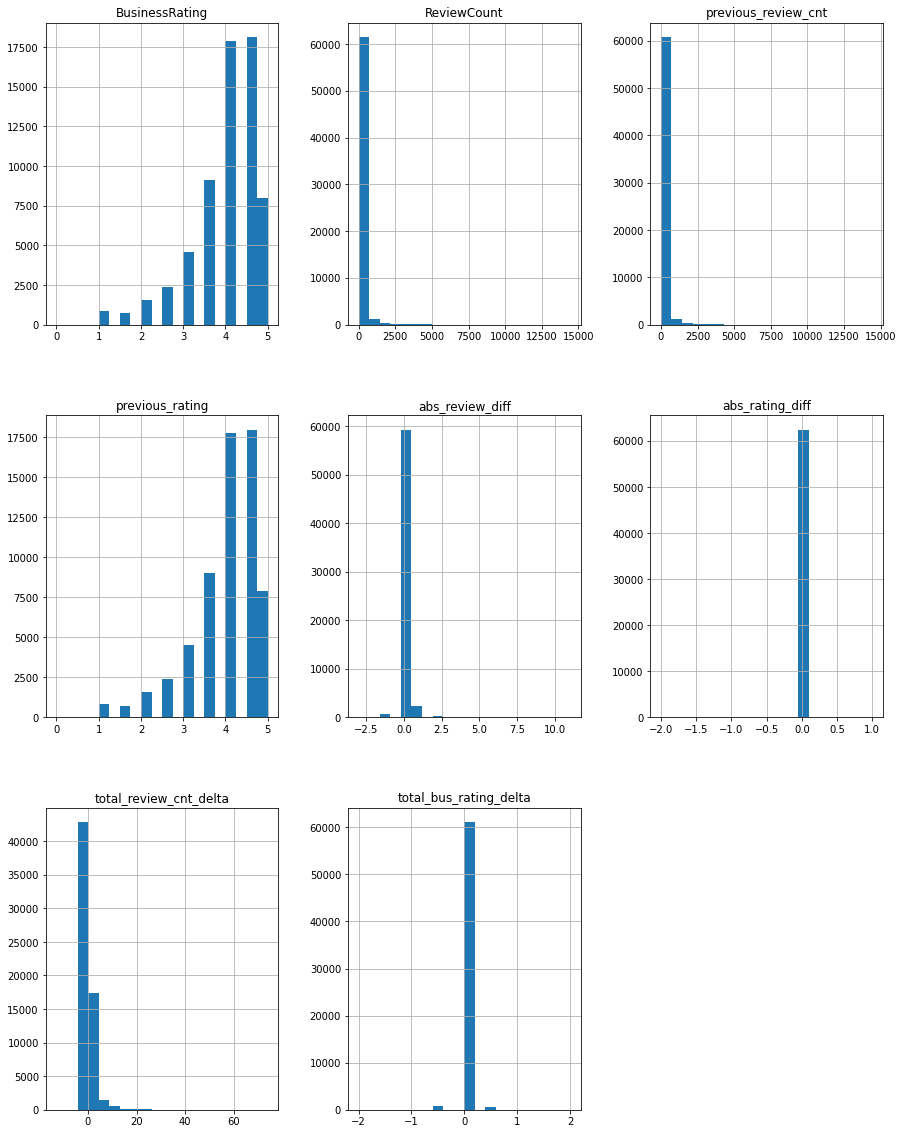

In [9]:
most_recent_holding.hist(bins=20,figsize=(15,20))

array([[<AxesSubplot:xlabel='BusinessRating', ylabel='BusinessRating'>,
        <AxesSubplot:xlabel='ReviewCount', ylabel='BusinessRating'>,
        <AxesSubplot:xlabel='total_bus_rating_delta', ylabel='BusinessRating'>,
        <AxesSubplot:xlabel='total_review_cnt_delta', ylabel='BusinessRating'>],
       [<AxesSubplot:xlabel='BusinessRating', ylabel='ReviewCount'>,
        <AxesSubplot:xlabel='ReviewCount', ylabel='ReviewCount'>,
        <AxesSubplot:xlabel='total_bus_rating_delta', ylabel='ReviewCount'>,
        <AxesSubplot:xlabel='total_review_cnt_delta', ylabel='ReviewCount'>],
       [<AxesSubplot:xlabel='BusinessRating', ylabel='total_bus_rating_delta'>,
        <AxesSubplot:xlabel='ReviewCount', ylabel='total_bus_rating_delta'>,
        <AxesSubplot:xlabel='total_bus_rating_delta', ylabel='total_bus_rating_delta'>,
        <AxesSubplot:xlabel='total_review_cnt_delta', ylabel='total_bus_rating_delta'>],
       [<AxesSubplot:xlabel='BusinessRating', ylabel='total_review_cnt_del

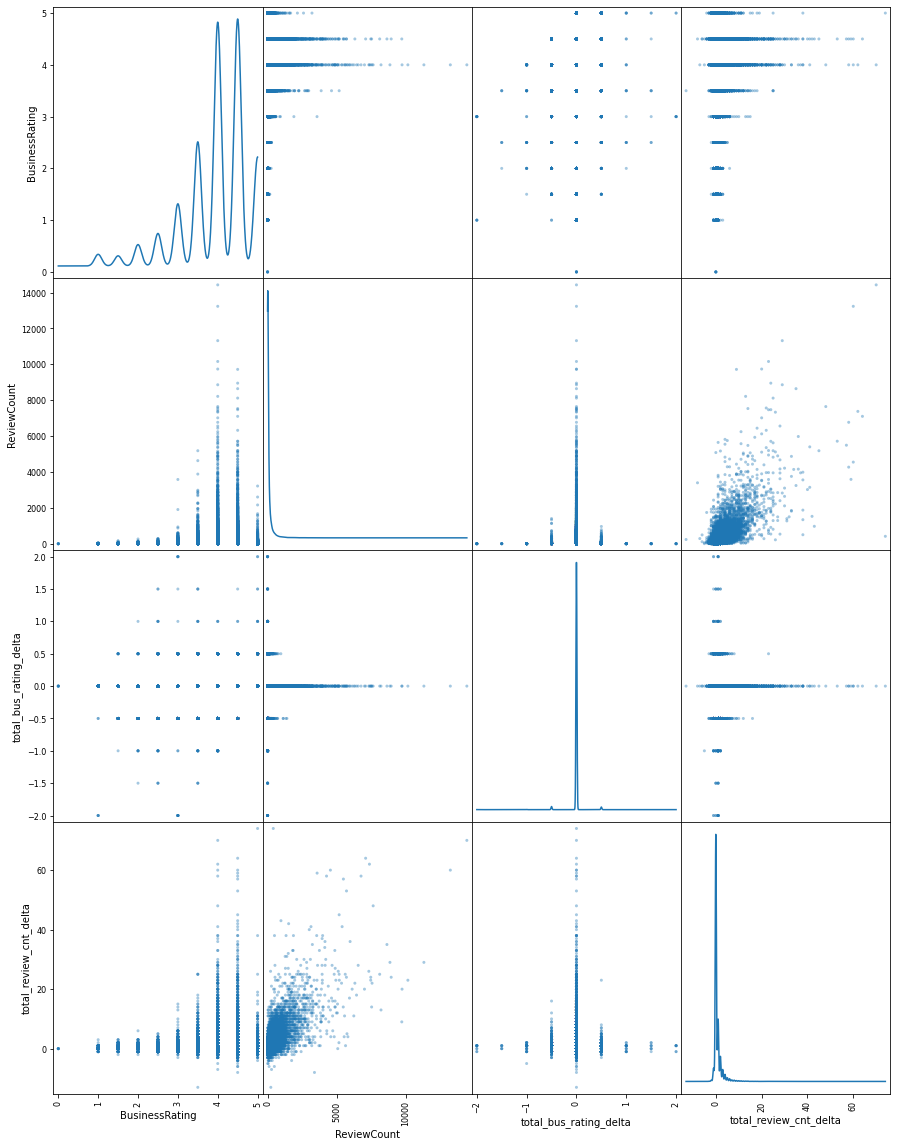

In [10]:
from pandas.plotting import scatter_matrix
# here we can see the correlation between different numeric values in effect showing the joint distribution
scatter_matrix(most_recent_holding[['BusinessRating', 'ReviewCount', 'total_bus_rating_delta', 'total_review_cnt_delta', 'CloseDate']], figsize=(15,20),alpha=.4, diagonal='kde')

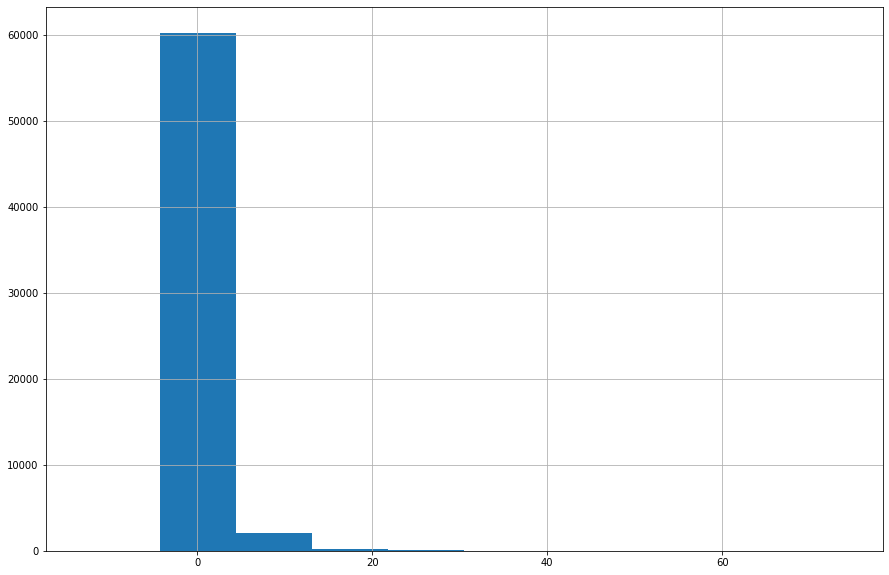

In [11]:
# fig, axs = plt.subplots(1,1)
# fig
# axs.hist(most_recent_holding['total_review_cnt_delta'], bins=30)
plt.figure(figsize= (15,10))
plt.hist(most_recent_holding['total_review_cnt_delta'], bins=10)
plt.grid()

Text(0.5, 1.0, 'Business Rating Δ Histogram')

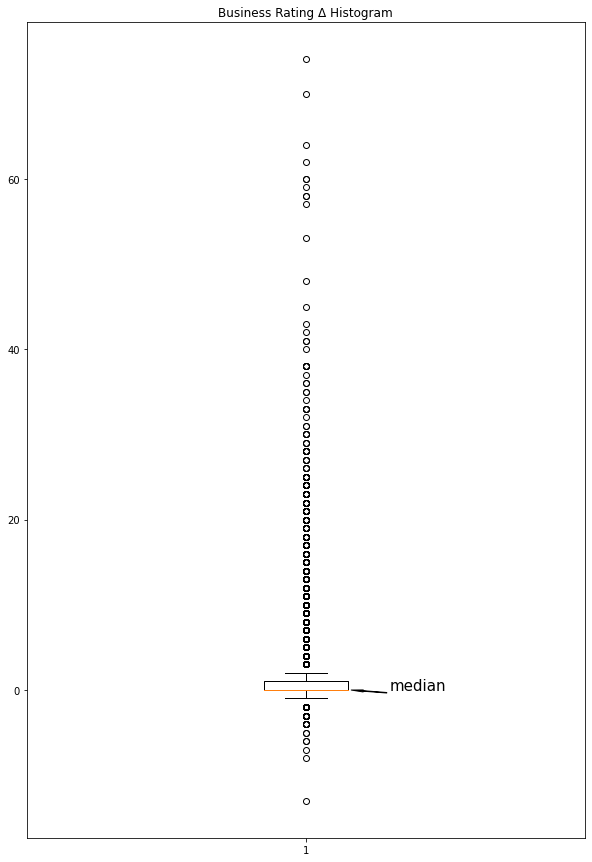

In [12]:
fig, ax = plt.subplots(figsize=(10, 15))
ax.boxplot(x=most_recent_holding['total_review_cnt_delta'].dropna(), vert=True)

plt.annotate('outlier threshold',xy=(1.05,780),xytext=(1.15,780),size=7,arrowprops=dict(facecolor='black',headwidth=2, width=0.5, shrink=0.02))

# plt.annotate('3rd quartile', xy=(1.08,570), xytext=(1.15,570), size=7, arrowprops=dict(facecolor='black', headwidth=2, width=0.5, shrink=0.02))
plt.annotate('median', xy=(1.08,most_recent_holding['total_review_cnt_delta'].median()), xytext=(1.15,most_recent_holding['total_review_cnt_delta'].median()), size=15, arrowprops=dict(facecolor='black', headwidth=2, width=0.5, shrink=0.02))
# plt.annotate('1st quartile', xy=(1.08,430), xytext=(1.15,430), size=7, arrowprops=dict(facecolor='black', headwidth=2, width=0.5, shrink=0.02))
# plt.annotate('outlier threshold', xy=(1.05,220), xytext=(1.15,220), size=7, arrowprops=dict(facecolor='black', headwidth=2, width=0.5, shrink=0.02))
ax.set_title(u'Business Rating Δ Histogram')


# plt.boxplot(most_recent_holding['total_review_cnt_delta'])

Text(0.5, 1.0, '')

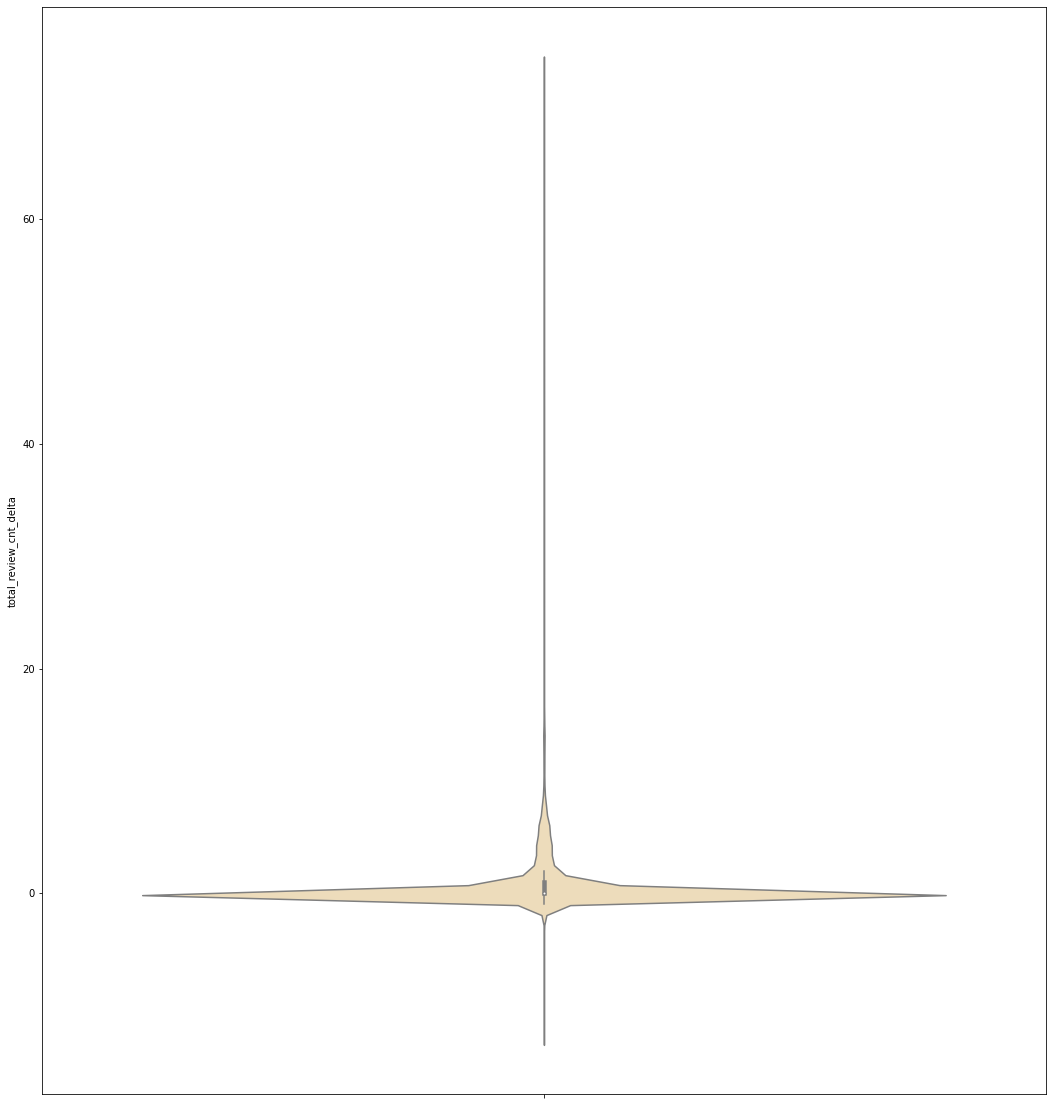

In [13]:
plt.figure(figsize=(18,20))
sns.violinplot( y = most_recent_holding['total_review_cnt_delta'], color='wheat',orient='v')
plt.title('')


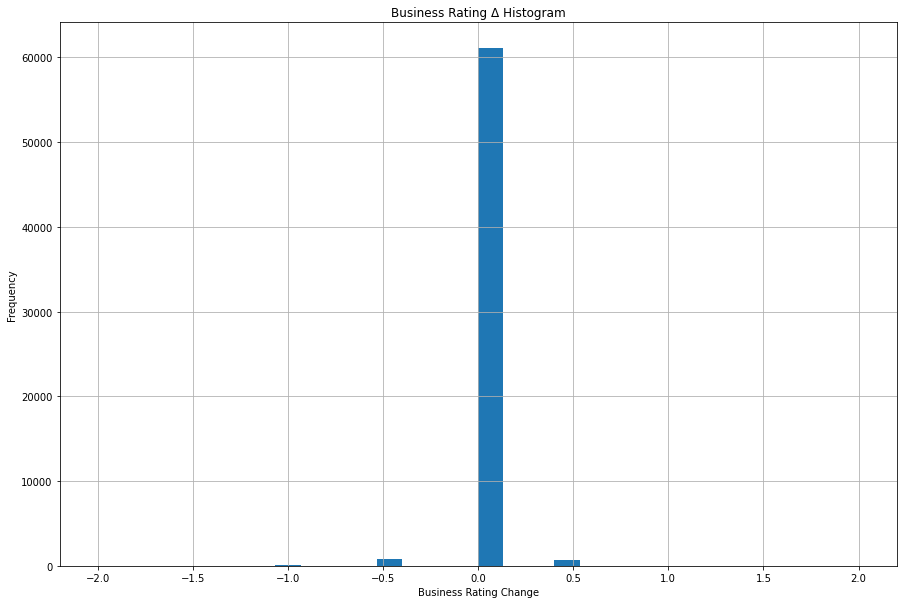

In [14]:
fig, ax = plt.subplots(figsize= (15,10))
ax.hist(most_recent_holding['total_bus_rating_delta'], bins=30)
ax.set_title(u'Business Rating Δ Histogram')
ax.set_ylabel('Frequency')
ax.set_xlabel('Business Rating Change')
ax.grid()
# plt.figure(figsize= (15,10))
# plt.hist(most_recent_holding['total_bus_rating_delta'], bins=30)

Over the span of a week or two our businesses haven't changed too much when we look at their total review count change or even the rating change. We can also take a more granular look at the data

In [15]:

most_recent_holding['total_review_cnt_delta'].agg(['size',np.mean, np.median, min, max, np.std] , axis=0).T

size     63,317.00
mean          0.76
median        0.00
min         -13.00
max          74.00
std           2.27
Name: total_review_cnt_delta, dtype: float64

In [16]:
print(most_recent_holding['total_review_cnt_delta'].value_counts(bins=10, normalize=True, sort=False))
print('\n')
print(most_recent_holding['total_review_cnt_delta'].value_counts(bins=10, sort=False))

(-13.088, -4.3]   0.00
(-4.3, 4.4]       0.95
(4.4, 13.1]       0.03
(13.1, 21.8]      0.00
(21.8, 30.5]      0.00
(30.5, 39.2]      0.00
(39.2, 47.9]      0.00
(47.9, 56.6]      0.00
(56.6, 65.3]      0.00
(65.3, 74.0]      0.00
Name: total_review_cnt_delta, dtype: float64


(-13.088, -4.3]        7
(-4.3, 4.4]        60232
(4.4, 13.1]         2015
(13.1, 21.8]         203
(21.8, 30.5]          75
(30.5, 39.2]          18
(39.2, 47.9]           6
(47.9, 56.6]           2
(56.6, 65.3]           8
(65.3, 74.0]           2
Name: total_review_cnt_delta, dtype: int64


In [17]:
print(most_recent_holding['total_bus_rating_delta'].value_counts(bins=10, normalize=True, sort=False))
print('\n')
print(most_recent_holding['total_bus_rating_delta'].value_counts(bins=10, sort=False))

(-2.005, -1.6]   0.00
(-1.6, -1.2]     0.00
(-1.2, -0.8]     0.00
(-0.8, -0.4]     0.01
(-0.4, 0.0]      0.96
(0.0, 0.4]       0.00
(0.4, 0.8]       0.01
(0.8, 1.2]       0.00
(1.2, 1.6]       0.00
(1.6, 2.0]       0.00
Name: total_bus_rating_delta, dtype: float64


(-2.005, -1.6]       12
(-1.6, -1.2]          7
(-1.2, -0.8]         40
(-0.8, -0.4]        758
(-0.4, 0.0]       61077
(0.0, 0.4]            0
(0.4, 0.8]          639
(0.8, 1.2]           19
(1.2, 1.6]            9
(1.6, 2.0]            7
Name: total_bus_rating_delta, dtype: int64


It seems there are a bucnbunchh of extreme values in the data , it might be best to go ahead and abstract some things a way as shown in the following table

In [18]:
pd.DataFrame.from_dict(
    {
        "Statistics": [
            "Mean",
            "Standard deviation",
            "Percent positive",
            "Percent zero",
            "Percent negative",
            "Number of observations",
        ],
        "Value": [
            most_recent_holding['total_bus_rating_delta'].describe()["mean"],
            most_recent_holding['total_bus_rating_delta'].describe()["std"],
            (most_recent_holding['total_bus_rating_delta'] > 0).sum() / most_recent_holding['total_bus_rating_delta'].shape[0] * 100,
            (most_recent_holding['total_bus_rating_delta'] == 0).sum() / most_recent_holding['total_bus_rating_delta'].shape[0] * 100,
            (most_recent_holding['total_bus_rating_delta'] < 0).sum() / most_recent_holding['total_bus_rating_delta'].shape[0] * 100,
            most_recent_holding['total_bus_rating_delta'].describe()["count"],
        ],
    }
)

Statistics     Value
0                    Mean     -0.00
1      Standard deviation      0.09
2        Percent positive      1.06
3            Percent zero     96.46
4        Percent negative      1.29
5  Number of observations 62,568.00

Here we can see 96% of the businesses didn't even get one review in that case no need to go as in-depth with the **total_bus_rating_delta** column

Looking at the absolute values of the review counts we can see that there are a good number of extreme values. We can separate these and see differences we find between the two groups.\
Looking ahead we probably would not want to discard these as they could serve as good dependent variables, if they were independent we would have more freedom in this respect.

In [19]:
thirdq, firstq = most_recent_holding['total_review_cnt_delta'].quantile(.75), most_recent_holding['total_review_cnt_delta'].quantile(.25)
quartilerange = 1.5 * (thirdq - firstq)
highoutlier, lowoutlier = quartilerange + thirdq, firstq - quartilerange
print(highoutlier, lowoutlier, sep='<---->')

2.5<---->-1.5


The above shows what can be considered an extreme value for the review counts and the following will show the criteria for the rating

In [20]:
thirdq2, firstq2 = most_recent_holding['total_bus_rating_delta'].quantile(.75), most_recent_holding['total_bus_rating_delta'].quantile(.25)
quartilerange2 = 1.5 * (thirdq2 - firstq2)
highoutlier2, lowoutlier2 = quartilerange2 + thirdq2, firstq2 - quartilerange2
print(highoutlier2, lowoutlier2, sep='<---->')

0.0<---->0.0


In [21]:
def get_outliers():
  dfout = pd.DataFrame(columns = most_recent_holding.columns, data=None) #initializes a dataframe with no values but all orig. columns from df
  for col in ['total_bus_rating_delta', 'total_review_cnt_delta']: # just going to loop through the numeric columns
    thirdq, firstq = most_recent_holding[col].quantile(0.75), most_recent_holding[col].quantile(0.25)
    quartilerange = 1.5*(thirdq-firstq)
    highoutlier, lowoutlier = quartilerange + thirdq, firstq - quartilerange
    df = most_recent_holding.loc[(most_recent_holding[col] > highoutlier) | (most_recent_holding[col] < lowoutlier)] # for each columns we will isolate the extreme values
    df = df.assign(varname = col, threshlow= lowoutlier, threshhigh= highoutlier) # creates 3 new columns that corresponds to a label and the high outlier , and then the low outlier for that label respectively
    dfout = pd.concat([dfout,df]) # just a simple concatenation of the dfs
  return dfout

extreme_df = get_outliers()

Now in this new dataframe any business that is considered an extreme value ,on the basis of any column, will be added to the dataframe. This allows a business to be added twice if it considered an extreme value by both of the columns we chose

In [22]:
extreme_df

BusinessName  \
47               zoners-pizza-wings-and-waffles-waycross   
130                                 zeus-flowood-flowood   
146                   zest-kitchen-and-bar-port-st-lucie   
233       zaxbys-chicken-fingers-and-buffalo-wings-perry   
239    zaxbys-chicken-fingers-and-buffalo-wings-morri...   
...                                                  ...   
63280                        111-park-espresso-bar-raton   
63281                              110-grill-rochester-2   
63284                              110-grill-braintree-2   
63297                         101-taiwanese-cuisine-reno   
63310                                10-north-main-minot   

                                     ChainName  BusinessRating ReviewCount  \
47            Zoner's Pizza, Wings and Waffles            2.50          15   
130                             Zeus - Flowood            4.00          32   
146                         Zest Kitchen & Bar            4.00          69   
233    Zaxby's Chicken Fingers & Buffalo Wings            2.00          33   
239    Zaxby's Chicken Fingers & Buffalo Wings            4.00           9   
...                                        ...             ...         ...   
63280                    111 Park Espresso Bar            4.50         136   
63281                                110 Grill            4.00         191   
63284                                110 Grill            4.00         463   
63297                    101 Taiwanese Cuisine            4.00        1143   
63310                            10 North Main            4.00         110   

        CloseDate  previous_review_cnt  previous_rating  abs_review_diff  \
47     2022-01-13                15.00             2.50             0.00   
130    2022-01-13                32.00             4.00             0.00   
146    2022-01-13                69.00             4.00             0.00   
233    2022-01-13                32.00             2.50             1.00   
239    2022-01-13                 9.00             4.00             0.00   
...           ...                  ...              ...              ...   
63280  2022-01-13               136.00             4.50             0.00   
63281  2022-01-13               190.00             4.00             1.00   
63284  2022-01-13               463.00             4.00             0.00   
63297  2022-01-13             1,142.00             4.00             1.00   
63310  2022-01-13               110.00             4.00             0.00   

       abs_rating_diff  total_review_cnt_delta  total_bus_rating_delta  \
47                0.00                    1.00                   -0.50   
130               0.00                    1.00                   -0.50   
146               0.00                    2.00                   -0.50   
233              -0.50                    3.00                   -0.50   
239               0.00                    2.00                    0.50   
...                ...                     ...                     ...   
63280             0.00                    3.00                    0.00   
63281             0.00                    4.00                    0.00   
63284             0.00                    6.00                    0.00   
63297             0.00                    6.00                    0.00   
63310             0.00                    3.00                    0.00   

                      varname  threshlow  threshhigh  
47     total_bus_rating_delta       0.00        0.00  
130    total_bus_rating_delta       0.00        0.00  
146    total_bus_rating_delta       0.00        0.00  
233    total_bus_rating_delta       0.00        0.00  
239    total_bus_rating_delta       0.00        0.00  
...                       ...        ...         ...  
63280  total_review_cnt_delta      -1.50        2.50  
63281  total_review_cnt_delta      -1.50        2.50  
63284  total_review_cnt_delta      -1.50        2.50  
63297  total_review_cnt_delta     

Here we have the names of the businesses considered extreme in both columns

In [23]:
grouped_extreme_df = extreme_df.groupby(['BusinessName'], as_index=False)['varname'].count()
grouped_extreme_df_bus = grouped_extreme_df.loc[grouped_extreme_df['varname'] > 1, ['BusinessName']]
grouped_extreme_df_bus

BusinessName
19                       207-bistro-and-blues-mccomb
33                           3natives-lakewood-ranch
36                          412-public-house-cullman
61                                  7908-aspen-aspen
165                                  aloy-dee-eustis
...                                              ...
6766    vinnys-italian-grill-and-pizzeria-stafford-2
6927                       woodys-steak-house-ottawa
6966         yellowfin-sushi-and-sake-bar-cape-coral
6990                  yummys-greek-restaurant-denton
7003  zaxbys-chicken-fingers-and-buffalo-wings-perry

[153 rows x 1 columns]

In [24]:
exe_most_recent_holding = most_recent_holding.loc[most_recent_holding['BusinessName'].isin(grouped_extreme_df_bus['BusinessName'].values), :]
exe_most_recent_holding = exe_most_recent_holding.reset_index(drop=True)
exe_most_recent_holding

BusinessName  \
0    zaxbys-chicken-fingers-and-buffalo-wings-perry   
1                    yummys-greek-restaurant-denton   
2           yellowfin-sushi-and-sake-bar-cape-coral   
3                         woodys-steak-house-ottawa   
4      vinnys-italian-grill-and-pizzeria-stafford-2   
..                                              ...   
148                                 aloy-dee-eustis   
149                                7908-aspen-aspen   
150                        412-public-house-cullman   
151                         3natives-lakewood-ranch   
152                     207-bistro-and-blues-mccomb   

                                   ChainName  BusinessRating  ReviewCount  \
0    Zaxby's Chicken Fingers & Buffalo Wings            2.00           33   
1                   Yummy's Greek Restaurant            4.50          156   
2                 YellowFin Sushi & Sake Bar            4.00          122   
3                        Woody's Steak House            2.50           85   
4           Vinny's Italian Grill & Pizzeria            3.50          260   
..                                       ...             ...          ...   
148                                 Aloy Dee            5.00           48   
149                               7908 Aspen            4.50           67   
150                         412 Public House            4.50          109   
151                                 3Natives            4.50           21   
152                       207 Bistro & Blues            4.00            5   

      CloseDate  previous_review_cnt  previous_rating  abs_review_diff  \
0    2022-01-13                32.00             2.50             1.00   
1    2022-01-13               156.00             4.50             0.00   
2    2022-01-13               122.00             4.00             0.00   
3    2022-01-13                85.00             2.50             0.00   
4    2022-01-13               260.00             3.50             0.00   
..          ...                  ...              ...              ...   
148  2022-01-13                48.00             5.00             0.00   
149  2022-01-13                67.00             4.50             0.00   
150  2022-01-13               109.00             4.50             0.00   
151  2022-01-13                21.00             4.50             0.00   
152  2022-01-13                 5.00             4.00             0.00   

     abs_rating_diff  total_review_cnt_delta  total_bus_rating_delta  
0              -0.50                    3.00                   -0.50  
1               0.00                    3.00                    0.50  
2               0.00                    4.00                   -0.50  
3               0.00                    3.00                   -0.50  
4               0.00                    7.00                   -0.50  
..               ...                     ...                     ...  
148             0.00                    3.00                    0.50  
149             0.00                    4.00                    0.50  
150             0.00                    3.00                    0.50  
151             0.00                    3.00                   -0.50  
152             0.00                   -3.00                   -0.50  

[153 rows x 11 columns]

Now that we have our extreme values we can look to discover what makes them different

In [25]:
print(exe_most_recent_holding['total_bus_rating_delta'].value_counts( ascending=False).sort_index())
print('\n')
print(exe_most_recent_holding['total_review_cnt_delta'].value_counts(ascending=False).sort_index())

-1.00     1
-0.50    96
0.50     56
Name: total_bus_rating_delta, dtype: int64


-5.00     1
-3.00     4
-2.00    11
3.00     64
4.00     36
5.00     15
6.00      8
7.00      6
8.00      2
9.00      2
10.00     1
12.00     1
16.00     1
23.00     1
Name: total_review_cnt_delta, dtype: int64


In [26]:
exe_most_recent_holding.describe(include='all')

BusinessName        ChainName  \
count                                              153              153   
unique                                             153              151   
top     zaxbys-chicken-fingers-and-buffalo-wings-perry  Texas Roadhouse   
freq                                                 1                2   
mean                                               NaN              NaN   
std                                                NaN              NaN   
min                                                NaN              NaN   
25%                                                NaN              NaN   
50%                                                NaN              NaN   
75%                                                NaN              NaN   
max                                                NaN              NaN   

        BusinessRating  ReviewCount   CloseDate  previous_review_cnt  \
count           153.00       153.00         153               153.00   
unique             NaN          NaN           2                  NaN   
top                NaN          NaN  2022-01-13                  NaN   
freq               NaN          NaN         152                  NaN   
mean              3.95       197.88         NaN               197.58   
std               0.63       258.87         NaN               258.74   
min               2.00         1.00         NaN                 1.00   
25%               3.50        30.00         NaN                30.00   
50%               4.00        86.00         NaN                86.00   
75%               4.50       279.00         NaN               278.00   
max               5.00     1,403.00         NaN             1,403.00   

        previous_rating  abs_review_diff  abs_rating_diff  \
count            153.00           153.00           153.00   
unique              NaN              NaN              NaN   
top                 NaN              NaN              NaN   
freq                NaN              NaN              NaN   
mean               3.97             0.30            -0.02   
std                0.63             0.64             0.15   
min                2.00            -1.00            -0.50   
25%                3.50             0.00             0.00   
50%                4.00             0.00             0.00   
75%                4.50             1.00             0.00   
max                5.00             5.00             0.50   

        total_review_cnt_delta  total_bus_rating_delta  
count                   153.00                  153.00  
unique                     NaN                     NaN  
top                        NaN                     NaN  
freq                       NaN                     NaN  
mean                      3.64                   -0.14  
std                       3.15                    0.49  
min                      -5.00                   -1.00  
25%                       3.00                   -0.50  
50%                       3.00                   -0.50  
75%                       4.00                    0.50  
max                      23.00                    0.50

It's going to be better to make a join with the categories, payment levels, and even county growth to get more information out . So to begin we'll join the data with `bus_cat_dataframe`

In [27]:
exe_most_recent_holding.to_csv('exe_most_recent_holding.csv',sep='|', index=False )


Here we have to remember that we'll get duplicate businesses due to there being categories involved

In [28]:
exe_most_recent_holding_loc = bus_cat_dataframe.merge(right=exe_most_recent_holding, how='inner', on = 'BusinessName')
exe_most_recent_holding_loc

BusinessKey                                       BusinessName  \
0           8355  tokyo-japanese-steakhouse-seafood-and-sushi-ba...   
1           8355  tokyo-japanese-steakhouse-seafood-and-sushi-ba...   
2           8355  tokyo-japanese-steakhouse-seafood-and-sushi-ba...   
3           9764              himalayan-curry-kitchen-richmond-hill   
4           9764              himalayan-curry-kitchen-richmond-hill   
..           ...                                                ...   
334        61281                new-fortune-asian-cuisine-cedarburg   
335        17260                       great-wall-restaurant-newton   
336        41725                       s-and-bs-burger-joint-lawton   
337         5962                               campo-de-fiori-aspen   
338        16766                                  flip-n-jacks-ames   

                                       ChainName_x PaymentLevelName  \
0    Tokyo Japanese Steakhouse Seafood & Sushi Bar              Low   
1    Tokyo Japanese Steakhouse Seafood & Sushi Bar              Low   
2    Tokyo Japanese Steakhouse Seafood & Sushi Bar              Low   
3                          Himalayan Curry Kitchen              Low   
4                          Himalayan Curry Kitchen              Low   
..                                             ...              ...   
334                      New Fortune Asian Cuisine              Low   
335                          Great Wall Restaurant         Very Low   
336                             S&B's Burger Joint              Low   
337                                 Campo De Fiori             High   
338                                   Flip’N Jacks          Unknown   

     Longitude  Latitude BusinessCategoryName       CityName       CountyName  \
0       -87.26     30.53             Japanese      Pensacola  Escambia County   
1       -87.26     30.53          Steakhouses      Pensacola  Escambia County   
2       -87.26     30.53           Sushi Bars      Pensacola  Escambia County   
3       -81.31     31.95               Indian  Richmond Hill     Bryan County   
4       -81.31     31.95   Himalayan/Nepalese  Richmond Hill     Bryan County   
..         ...       ...                  ...            ...              ...   
334     -87.99     43.30              Chinese      Cedarburg   Ozaukee County   
335     -97.34     38.01              Chinese         Newton    Harvey County   
336     -98.44     34.62              Burgers         Lawton  Comanche County   
337    -106.82     39.19              Italian          Aspen    Pitkin County   
338     -93.58     42.01             Pancakes           Ames     Story County   

     StateName  ...                                    ChainName_y  \
0      Florida  ...  Tokyo Japanese Steakhouse Seafood & Sushi Bar   
1      Florida  ...  Tokyo Japanese Steakhouse Seafood & Sushi Bar   
2      Florida  ...  Tokyo Japanese Steakhouse Seafood & Sushi Bar   
3      Georgia  ...                        Himalayan Curry Kitchen   
4      Georgia  ...                        Himalayan Curry Kitchen   
..         ...  ...                                            ...   
334  Wisconsin  ...                      New Fortune Asian Cuisine   
335     Kansas  ...                          Great Wall Restaurant   
336   Oklahoma  ...                             S&B's Burger Joint   
337   Colorado  ...                                 Campo De Fiori   
338       Iowa  ...                                   Flip’N Jacks   

    BusinessRating  ReviewCount   CloseDate previous_review_cnt  \
0             2.50           90  2022-01-13               90.00   
1             2.50           90  2022-01-13               90.00   
2             2.50           90  2022-01-13               90.00   
3             4.50          231  2022-01-13              230.00   
4             4.50          231  2022-01-13              230.00   
..             ...          ...         ...                 ...   
334           4.

In [29]:
exe_most_recent_holding_loc.describe(include='all')

BusinessKey                                       BusinessName  \
count        339.00                                                339   
unique          NaN                                                153   
top             NaN  tokyo-japanese-steakhouse-seafood-and-sushi-ba...   
freq            NaN                                                  3   
mean      26,927.25                                                NaN   
std       20,453.63                                                NaN   
min          323.00                                                NaN   
25%        8,036.00                                                NaN   
50%       21,721.00                                                NaN   
75%       46,301.00                                                NaN   
max       62,891.00                                                NaN   

            ChainName_x PaymentLevelName  Longitude  Latitude  \
count               339              339     339.00    339.00   
unique              151                5        NaN       NaN   
top     Texas Roadhouse              Low        NaN       NaN   
freq                  6              180        NaN       NaN   
mean                NaN              NaN     -93.15     35.88   
std                 NaN              NaN      16.14      5.54   
min                 NaN              NaN    -159.32     18.47   
25%                 NaN              NaN    -104.79     31.95   
50%                 NaN              NaN     -87.26     36.30   
75%                 NaN              NaN     -81.64     39.72   
max                 NaN              NaN     -66.11     48.94   

          BusinessCategoryName CityName      CountyName StateName  ...  \
count                      339      339             339       339  ...   
unique                      78      142             136        41  ...   
top     American (Traditional)     Reno  Manatee County   Florida  ...   
freq                        22        7              11        49  ...   
mean                       NaN      NaN             NaN       NaN  ...   
std                        NaN      NaN             NaN       NaN  ...   
min                        NaN      NaN             NaN       NaN  ...   
25%                        NaN      NaN             NaN       NaN  ...   
50%                        NaN      NaN             NaN       NaN  ...   
75%                        NaN      NaN             NaN       NaN  ...   
max                        NaN      NaN             NaN       NaN  ...   

            ChainName_y BusinessRating  ReviewCount   CloseDate  \
count               339         339.00       339.00         339   
unique              151            NaN          NaN           2   
top     Texas Roadhouse            NaN          NaN  2022-01-13   
freq                  6            NaN          NaN         338   
mean                NaN           3.95       215.75         NaN   
std                 NaN           0.63       276.72         NaN   
min                 NaN           2.00         1.00         NaN   
25%                 NaN           3.50        33.00         NaN   
50%                 NaN           4.00       105.00         NaN   
75%                 NaN           4.50       307.50         NaN   
max                 NaN           5.00     1,403.00         NaN   

       previous_review_cnt  previous_rating  abs_review_diff  abs_rating_diff  \
count               339.00           339.00           339.00           339.00   
unique                 NaN              NaN              NaN              NaN   
top                    NaN              NaN              NaN              NaN   
freq                   NaN              NaN              NaN              NaN   
mean                215.42             3.97             0.33            -0.02   
std                 276.58             0.64             0.64             0.16   
min                   1.00             2.00            -1.00            -0.50

Here we're just going to want to take to explore the categories and after remove the duplicates to not create noise in the other categories

In [30]:
top_15_bus_cat = exe_most_recent_holding_loc['BusinessCategoryName'].value_counts(normalize=True).head(15)
top_15_bus_cat

American (Traditional)   0.06
Steakhouses              0.05
Breakfast & Brunch       0.05
Sushi Bars               0.04
Burgers                  0.04
Seafood                  0.04
Sandwiches               0.04
Japanese                 0.04
Mexican                  0.04
Coffee & Tea             0.03
Bars                     0.03
Italian                  0.03
Pizza                    0.03
Salad                    0.02
Chicken Wings            0.02
Name: BusinessCategoryName, dtype: float64

Before making comparisons with our other data we're going to remove the extreme values from it to get a clean comparision

In [31]:
most_recent_holding_sin_exe = most_recent_holding[~most_recent_holding['BusinessName'].isin(grouped_extreme_df_bus['BusinessName'].values)]
most_recent_holding_sin_exe = most_recent_holding_sin_exe.reset_index(drop=True)
most_recent_holding_sin_exe

BusinessName                ChainName  \
0        él-torito-restaurant-georgetown     Él Torito Restaurant   
1                        ándale-caguas-2                   Ándale   
2                        àlavita-boise-2                  ÀLAVITA   
3              zzzz-s-pizzzza-burlington           ZZZZ’s PIzzzza   
4        zzs-sports-bar-and-grill-adrian  ZZ's Sports Bar & Grill   
...                                  ...                      ...   
63159           10-40-coffee-west-plains             10/40 Coffee   
63160  1-north-steakhouse-hampton-bays-2       1 North Steakhouse   
63161       1-more-bar-and-grille-bright      1 More Bar & Grille   
63162                    1-cow-ten-sleep                    1 Cow   
63163      1-chinese-restaurant-coinjock     1 Chinese Restaurant   

       BusinessRating  ReviewCount   CloseDate  previous_review_cnt  \
0                4.00            2  2022-01-13                 2.00   
1                5.00            3  2022-01-13                 3.00   
2                4.00          304  2022-01-13               304.00   
3                5.00            1  2022-01-13                 1.00   
4                3.50           10  2022-01-13                10.00   
...               ...          ...         ...                  ...   
63159            5.00           11  2022-01-13                11.00   
63160            4.00          149  2022-01-13               149.00   
63161            4.00            9  2022-01-13                 9.00   
63162            4.50            6  2022-01-13                 6.00   
63163            3.00            2  2022-01-13                 2.00   

       previous_rating  abs_review_diff  abs_rating_diff  \
0                 4.00             0.00             0.00   
1                 5.00             0.00             0.00   
2                 4.00             0.00             0.00   
3                 5.00             0.00             0.00   
4                 3.50             0.00             0.00   
...                ...              ...              ...   
63159             5.00             0.00             0.00   
63160             4.00             0.00             0.00   
63161             4.00             0.00             0.00   
63162             4.50             0.00             0.00   
63163             3.00             0.00             0.00   

       total_review_cnt_delta  total_bus_rating_delta  
0                        0.00                    0.00  
1                        0.00                    0.00  
2                        0.00                    0.00  
3                        0.00                    0.00  
4                        0.00                    0.00  
...                       ...                     ...  
63159                    0.00                    0.00  
63160                    2.00                    0.00  
63161                    0.00                    0.00  
63162                    0.00                    0.00  
63163                    0.00                    0.00  

[63164 rows x 11 columns]

Here we'll merge our data with the business categories

In [32]:
most_recent_holding_cat_sin_exe = bus_cat_dataframe.merge(right=most_recent_holding_sin_exe[['BusinessName']], how='inner', on = 'BusinessName')
most_recent_holding_cat_sin_exe

BusinessKey                             BusinessName  \
0                23         eastern-shore-street-eats-daphne   
1                23         eastern-shore-street-eats-daphne   
2                33              chris-hot-dogs-montgomery-2   
3               122  benjas-thai-and-sushi-restaurant-mobile   
4               122  benjas-thai-and-sushi-restaurant-mobile   
...             ...                                      ...   
126183        62893                        munchies-evanston   
126184        63106       don-juan-mexican-restaurant-casper   
126185        63128        the-hangar-bar-and-grill-bar-nunn   
126186        63155                 wyoming-hot-wings-casper   
126187        63221  rendezvous-meadows-golf-course-pinedale   

                              ChainName PaymentLevelName  Longitude  Latitude  \
0             Eastern Shore Street Eats          Unknown     -87.87     30.61   
1             Eastern Shore Street Eats          Unknown     -87.87     30.61   
2                       Chris' Hot Dogs         Very Low     -86.31     32.38   
3       Benja's Thai & Sushi Restaurant              Low     -88.19     30.66   
4       Benja's Thai & Sushi Restaurant              Low     -88.19     30.66   
...                                 ...              ...        ...       ...   
126183                         Munchies          Unknown    -110.97     41.27   
126184      Don Juan Mexican Restaurant         Very Low    -106.33     42.85   
126185         The Hangar Bar And Grill              Low    -106.34     42.91   
126186                Wyoming Hot Wings              Low    -106.30     42.84   
126187   Rendezvous Meadows Golf Course          Unknown    -109.88     42.86   

          BusinessCategoryName    CityName       CountyName StateName  \
0       American (Traditional)      Daphne   Baldwin County   Alabama   
1                  Food Trucks      Daphne   Baldwin County   Alabama   
2                     Hot Dogs  Montgomery   Autauga County   Alabama   
3                   Sushi Bars      Mobile    Mobile County   Alabama   
4                         Thai      Mobile    Mobile County   Alabama   
...                        ...         ...              ...       ...   
126183                Hot Dogs    Evanston     Uinta County   Wyoming   
126184                 Mexican      Casper   Natrona County   Wyoming   
126185  American (Traditional)    Bar Nunn   Natrona County   Wyoming   
126186           Chicken Wings      Casper  Converse County   Wyoming   
126187                    Golf    Pinedale  Sublette County   Wyoming   

       CountryName  
0               US  
1               US  
2               US  
3               US  
4               US  
...            ...  
126183          US  
126184          US  
126185          US  
126186          US  
126187          US  

[126188 rows x 11 columns]

Recap of the cateogories in the `exe_most_recent_holding_loc` dataframe

In [33]:
top_15_bus_cat

American (Traditional)   0.06
Steakhouses              0.05
Breakfast & Brunch       0.05
Sushi Bars               0.04
Burgers                  0.04
Seafood                  0.04
Sandwiches               0.04
Japanese                 0.04
Mexican                  0.04
Coffee & Tea             0.03
Bars                     0.03
Italian                  0.03
Pizza                    0.03
Salad                    0.02
Chicken Wings            0.02
Name: BusinessCategoryName, dtype: float64

Some of these top categories look rather familiar we're going to check our original data and compare them

In [34]:
top_15_bus_cat_orig = most_recent_holding_cat_sin_exe['BusinessCategoryName'].value_counts(normalize=True).head(15)
top_15_bus_cat_orig

American (Traditional)      0.07
Pizza                       0.05
Burgers                     0.05
Sandwiches                  0.05
Mexican                     0.05
Breakfast & Brunch          0.05
Fast Food                   0.04
Coffee & Tea                0.04
Seafood                     0.03
American (New)              0.03
Bars                        0.03
Italian                     0.02
Ice Cream & Frozen Yogurt   0.02
Barbeque                    0.02
Bakeries                    0.02
Name: BusinessCategoryName, dtype: float64

We'll compare them side-by-side

In [35]:
top_15_bus_cat.reset_index().merge(right=top_15_bus_cat_orig.reset_index(), on='index', how='outer')

index  BusinessCategoryName_x  BusinessCategoryName_y
0      American (Traditional)                    0.06                    0.07
1                 Steakhouses                    0.05                     NaN
2          Breakfast & Brunch                    0.05                    0.05
3                  Sushi Bars                    0.04                     NaN
4                     Burgers                    0.04                    0.05
5                     Seafood                    0.04                    0.03
6                  Sandwiches                    0.04                    0.05
7                    Japanese                    0.04                     NaN
8                     Mexican                    0.04                    0.05
9                Coffee & Tea                    0.03                    0.04
10                       Bars                    0.03                    0.03
11                    Italian                    0.03                    0.02
12                      Pizza                    0.03                    0.05
13                      Salad                    0.02                     NaN
14              Chicken Wings                    0.02                     NaN
15                  Fast Food                     NaN                    0.04
16             American (New)                     NaN                    0.03
17  Ice Cream & Frozen Yogurt                     NaN                    0.02
18                   Barbeque                     NaN                    0.02
19                   Bakeries                     NaN                    0.02

> **remove nulls and make connection that there is good overlap between the most popular categories extreme values dataset and also the original... so we have to look further for some other independent variable**

> in future go back and take percentage differences to reduce effect of extreme values even more

Now we're going to checkout some conditional probailities on the basis of the `PaymentLevelName` as to see whether some values tend to have higher ratings than others and after we'll create bins for thre review counts and do the same there\
[Reference](https://fromlawtodata.com/how-to-make-a-100-stacked-bar-chart-with-python/)

In [36]:
df1 = most_recent_holding_cat_sin_exe.drop_duplicates(subset=['BusinessName','PaymentLevelName']).reset_index(drop=True)
df2 = most_recent_holding.merge(right=df1, how='inner', on = 'BusinessName')


In [37]:
# rounding will need robustness check to see what effect it has on analysis results
df2['rating_groups'] =  df2['BusinessRating'].map(round)
df2

BusinessName              ChainName_x  \
0        él-torito-restaurant-georgetown     Él Torito Restaurant   
1                        ándale-caguas-2                   Ándale   
2                        àlavita-boise-2                  ÀLAVITA   
3              zzzz-s-pizzzza-burlington           ZZZZ’s PIzzzza   
4        zzs-sports-bar-and-grill-adrian  ZZ's Sports Bar & Grill   
...                                  ...                      ...   
63153           10-40-coffee-west-plains             10/40 Coffee   
63154  1-north-steakhouse-hampton-bays-2       1 North Steakhouse   
63155       1-more-bar-and-grille-bright      1 More Bar & Grille   
63156                    1-cow-ten-sleep                    1 Cow   
63157      1-chinese-restaurant-coinjock     1 Chinese Restaurant   

       BusinessRating  ReviewCount   CloseDate  previous_review_cnt  \
0                4.00            2  2022-01-13                 2.00   
1                5.00            3  2022-01-13                 3.00   
2                4.00          304  2022-01-13               304.00   
3                5.00            1  2022-01-13                 1.00   
4                3.50           10  2022-01-13                10.00   
...               ...          ...         ...                  ...   
63153            5.00           11  2022-01-13                11.00   
63154            4.00          149  2022-01-13               149.00   
63155            4.00            9  2022-01-13                 9.00   
63156            4.50            6  2022-01-13                 6.00   
63157            3.00            2  2022-01-13                 2.00   

       previous_rating  abs_review_diff  abs_rating_diff  \
0                 4.00             0.00             0.00   
1                 5.00             0.00             0.00   
2                 4.00             0.00             0.00   
3                 5.00             0.00             0.00   
4                 3.50             0.00             0.00   
...                ...              ...              ...   
63153             5.00             0.00             0.00   
63154             4.00             0.00             0.00   
63155             4.00             0.00             0.00   
63156             4.50             0.00             0.00   
63157             3.00             0.00             0.00   

       total_review_cnt_delta  ...              ChainName_y  PaymentLevelName  \
0                        0.00  ...     Él Torito Restaurant           Unknown   
1                        0.00  ...                   Ándale           Unknown   
2                        0.00  ...                  ÀLAVITA               Low   
3                        0.00  ...           ZZZZ’s PIzzzza           Unknown   
4                        0.00  ...  ZZ's Sports Bar & Grill               Low   
...                       ...  ...                      ...               ...   
63153                    0.00  ...             10/40 Coffee           Unknown   
63154                    2.00  ...       1 North Steakhouse              High   
63155                    0.00  ...      1 More Bar & Grille          Very Low   
63156                    0.00  ...                    1 Cow           Unknown   
63157                    0.00  ...     1 Chinese Restaurant           Unknown   

      Longitude Latitude    BusinessCategoryName      CityName  \
0        -75.39    38.69                 Spanish    Georgetown   
1        -66.04    18.26                 Mexican        Caguas   
2       -116.20    43.62                 Italian         Boise   
3       -102.27    39.30                   Pizza    Burlington   
4        -84.04    41.90  American (Traditional)        Adrian   
...         ...      ...                     ...           ...   
63153    -91.85    36.73            Coffee & Tea   West Plains   
63154    -72.56    40.86             Steakhouses  Hampton Bays   
63155    -84.85    39.22  American (Traditional)        Br

In [38]:
df2_groups = df2.groupby(['rating_groups', 'PaymentLevelName'],as_index=False).agg({'ReviewCount': 'sum'})
df2_groups

rating_groups PaymentLevelName  ReviewCount
0               1             High            3
1               1              Low           32
2               1          Unknown          742
3               1        Very High            5
4               1         Very Low         1382
5               2             High          554
6               2              Low        25527
7               2          Unknown         5748
8               2        Very High           72
9               2         Very Low        33523
10              3             High         2778
11              3              Low       106156
12              3          Unknown         8476
13              3        Very High          283
14              3         Very Low        28975
15              4             High       511270
16              4              Low      4931523
17              4          Unknown       272914
18              4        Very High        93920
19              4         Very Low      1074859
20              5             High         4411
21              5              Low        69114
22              5          Unknown        59259
23              5        Very High          339
24              5         Very Low        59907

In [39]:
df2_groups_pivoted = df2_groups.pivot(index='PaymentLevelName', columns = 'rating_groups', values='ReviewCount')
df2_groups_pivoted

rating_groups        1      2       3        4      5
PaymentLevelName                                     
High                 3    554    2778   511270   4411
Low                 32  25527  106156  4931523  69114
Unknown            742   5748    8476   272914  59259
Very High            5     72     283    93920    339
Very Low          1382  33523   28975  1074859  59907

In [40]:
#changing format here to prevent some confusion with decimals
pd.options.display.float_format = '{:,.4f}'.format
df2_groups_pivoted_100 = df2_groups_pivoted.div(df2_groups_pivoted.sum(axis=1), axis=0)
df2_groups_pivoted_100

rating_groups         1      2      3      4      5
PaymentLevelName                                   
High             0.0000 0.0011 0.0054 0.9851 0.0085
Low              0.0000 0.0050 0.0207 0.9609 0.0135
Unknown          0.0021 0.0166 0.0244 0.7862 0.1707
Very High        0.0001 0.0008 0.0030 0.9926 0.0036
Very Low         0.0012 0.0280 0.0242 0.8967 0.0500

In [41]:
# this will calculate the sum of the data in the first column to begin then on the next pass will included the subsequent
# column and so on and so forth inorder to stack each column on top of the previous one 
bottom_list = []
for i in df2_groups_pivoted_100.columns:
    b = list(df2_groups_pivoted_100.loc[:, df2_groups_pivoted_100.columns[0]: i].sum(axis=1))
    bottom_list.append(b)
bottom_list

[[5.7801686267860725e-06,
  6.2349581634307234e-06,
  0.002137472309363108,
  5.284350923176106e-05,
  0.00115296759844024],
 [0.001073184641706614,
  0.004979977990597683,
  0.018695680980817482,
  0.0008137900421691203,
  0.029120357470011998],
 [0.006425620790110517,
  0.02566367232800868,
  0.04311241318319175,
  0.0038047326646867964,
  0.05329346612761399],
 [0.9915012253957489,
  0.9865336594216453,
  0.8292931649857838,
  0.9964172100740867,
  0.9500211071492334],
 [1.0, 1.0, 1.0, 1.0, 1.0]]

What's interesting is that those that had an unknown value for `PaymentLevelName` had the highest probability of having 5 stars as a business. Approximately 17% 😮!But next up would be `Very Low`. And ultimately the lowest is `Very High`. This could be perhaps due to the higher scrutiny and standards it will be held to 🤔.

/tmp/ipykernel_1786/1993681205.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0%}'.format(y) for y in y_vals])


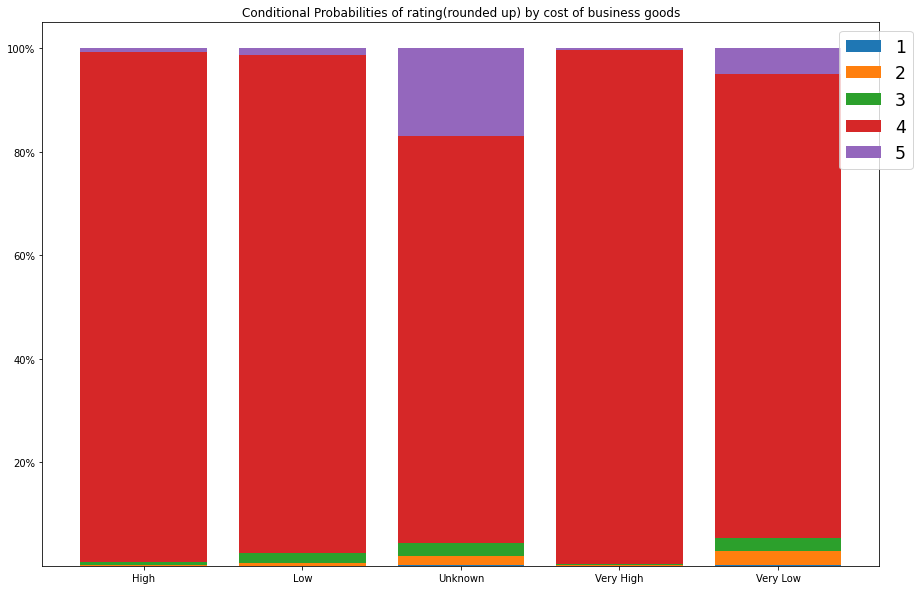

In [42]:
fig, ax = plt.subplots(figsize=(15,10))

x_ax = df2_groups_pivoted_100.index

for i, v in enumerate(df2_groups_pivoted_100.columns):
    if i == 0:
        plt.bar(x_ax, df2_groups_pivoted_100[v])
    else:
        plt.bar(x_ax, df2_groups_pivoted_100[v], bottom=bottom_list[i - 1])

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(y) for y in y_vals])
ax.legend(labels=df2_groups_pivoted_100.columns, bbox_to_anchor=(1.05, 1),loc='upper right',fontsize='xx-large')
plt.title('Conditional Probabilities of rating(rounded up) by cost of business goods')
plt.show()

Now we will take a look at some of the conditional means of the amount by which a state grew on intervals of the total review (i.e. the distribution of the county population change averages conditioned on the review count change) count change for a business. This will be done using bins of 3 and 10

In [43]:
df3 = pd.merge(left=df2, right = cg_dataframe, left_on=['CountyName','StateName'], right_on=['CountyName','StateName'])
df3

BusinessName                   ChainName_x  \
0            él-torito-restaurant-georgetown          Él Torito Restaurant   
1             truck-it-food-truck-georgetown           Truck It Food Truck   
2                        the-fox-hole-milton                  The Fox Hole   
3                        the-backyard-milton                  The Backyard   
4          tequila-real-mexican-grill-milton    Tequila Real Mexican Grill   
...                                      ...                           ...   
61256             boneshaker-coffee-bismarck             Boneshaker Coffee   
61257  a-and-b-pizza-north-bismarck-bismarck  A & B Pizza - North Bismarck   
61258             chippers-downtown-meeker-2             Chippers Downtown   
61259                    bennys-grille-lakin                Benny's Grille   
61260                        arbys-tucumcari                         Arbys   

       BusinessRating  ReviewCount   CloseDate  previous_review_cnt  \
0              4.0000            2  2022-01-13               2.0000   
1              5.0000            1  2022-01-13               1.0000   
2              4.5000           17  2022-01-13              17.0000   
3              4.0000          143  2022-01-13             143.0000   
4              4.5000           51  2022-01-13              51.0000   
...               ...          ...         ...                  ...   
61256          3.5000           34  2022-01-13              34.0000   
61257          3.5000           39  2022-01-13              39.0000   
61258          5.0000            1  2022-01-13               1.0000   
61259          1.0000            1  2022-01-13               1.0000   
61260          2.5000            4  2022-01-13               4.0000   

       previous_rating  abs_review_diff  abs_rating_diff  \
0               4.0000           0.0000           0.0000   
1               5.0000           0.0000           0.0000   
2               4.5000           0.0000           0.0000   
3               4.0000           0.0000           0.0000   
4               4.5000           0.0000           0.0000   
...                ...              ...              ...   
61256           3.5000           0.0000           0.0000   
61257           3.5000           0.0000           0.0000   
61258           5.0000           0.0000           0.0000   
61259           1.0000           0.0000           0.0000   
61260           2.5000           0.0000           0.0000   

       total_review_cnt_delta  ...    CityName         CountyName  \
0                      0.0000  ...  Georgetown      Sussex County   
1                      0.0000  ...  Georgetown      Sussex County   
2                     -1.0000  ...      Milton      Sussex County   
3                      1.0000  ...      Milton      Sussex County   
4                     -1.0000  ...      Milton      Sussex County   
...                       ...  ...         ...                ...   
61256                  0.0000  ...    Bismarck    Burleigh County   
61257                  0.0000  ...    Bismarck    Burleigh County   
61258                  0.0000  ...      Meeker  Rio Blanco County   
61259                  0.0000  ...       Lakin      Kearny County   
61260                  0.0000  ...   Tucumcari        Quay County   

          StateName CountryName  rating_groups  EstimationYear  \
0          Delaware          US              4            2019   
1          Delaware          US              5            2019   
2          Delaware          US              4            2019   
3          Delaware          US              4            2019   
4          Delaware          US              4            2019   
...             ...         ...            ...             ...   
61256  North Dakota          US              4            2019   
61257  North Dakota          US              4            2019   
61258      Colorado          US              5            2019   
61259        Kansas          US 

In [44]:
df3.columns

Index(['BusinessName', 'ChainName_x', 'BusinessRating', 'ReviewCount',
       'CloseDate', 'previous_review_cnt', 'previous_rating',
       'abs_review_diff', 'abs_rating_diff', 'total_review_cnt_delta',
       'total_bus_rating_delta', 'BusinessKey', 'ChainName_y',
       'PaymentLevelName', 'Longitude', 'Latitude', 'BusinessCategoryName',
       'CityName', 'CountyName', 'StateName', 'CountryName', 'rating_groups',
       'EstimationYear', 'EstimatedPopulation', 'lastpop', 'relative_delta',
       'abs_delta'],
      dtype='object')

In [75]:
bins_of_10 = pd.cut(df3['EstimatedPopulation'], bins=10)
bins_of_3 = pd.cut(df3['EstimatedPopulation'], bins=3)

In [76]:
bins_of_3

0        (-9953.021, 3346426.333]
1        (-9953.021, 3346426.333]
2        (-9953.021, 3346426.333]
3        (-9953.021, 3346426.333]
4        (-9953.021, 3346426.333]
                   ...           
61256    (-9953.021, 3346426.333]
61257    (-9953.021, 3346426.333]
61258    (-9953.021, 3346426.333]
61259    (-9953.021, 3346426.333]
61260    (-9953.021, 3346426.333]
Name: EstimatedPopulation, Length: 61261, dtype: category
Categories (3, interval[float64, right]): [(-9953.021, 3346426.333] < (3346426.333, 6692766.667] < (6692766.667, 10039107.0]]

In [77]:
df_bins = pd.concat([bins_of_3, bins_of_10], axis=1)
df_bins.columns = ['bins_of_3', 'bins_of_10']

In [78]:
df3_w_bins =  pd.concat([df3, df_bins], axis=1)
df3_w_bins

BusinessName                   ChainName_x  \
0            él-torito-restaurant-georgetown          Él Torito Restaurant   
1             truck-it-food-truck-georgetown           Truck It Food Truck   
2                        the-fox-hole-milton                  The Fox Hole   
3                        the-backyard-milton                  The Backyard   
4          tequila-real-mexican-grill-milton    Tequila Real Mexican Grill   
...                                      ...                           ...   
61256             boneshaker-coffee-bismarck             Boneshaker Coffee   
61257  a-and-b-pizza-north-bismarck-bismarck  A & B Pizza - North Bismarck   
61258             chippers-downtown-meeker-2             Chippers Downtown   
61259                    bennys-grille-lakin                Benny's Grille   
61260                        arbys-tucumcari                         Arbys   

       BusinessRating  ReviewCount   CloseDate  previous_review_cnt  \
0              4.0000            2  2022-01-13               2.0000   
1              5.0000            1  2022-01-13               1.0000   
2              4.5000           17  2022-01-13              17.0000   
3              4.0000          143  2022-01-13             143.0000   
4              4.5000           51  2022-01-13              51.0000   
...               ...          ...         ...                  ...   
61256          3.5000           34  2022-01-13              34.0000   
61257          3.5000           39  2022-01-13              39.0000   
61258          5.0000            1  2022-01-13               1.0000   
61259          1.0000            1  2022-01-13               1.0000   
61260          2.5000            4  2022-01-13               4.0000   

       previous_rating  abs_review_diff  abs_rating_diff  \
0               4.0000           0.0000           0.0000   
1               5.0000           0.0000           0.0000   
2               4.5000           0.0000           0.0000   
3               4.0000           0.0000           0.0000   
4               4.5000           0.0000           0.0000   
...                ...              ...              ...   
61256           3.5000           0.0000           0.0000   
61257           3.5000           0.0000           0.0000   
61258           5.0000           0.0000           0.0000   
61259           1.0000           0.0000           0.0000   
61260           2.5000           0.0000           0.0000   

       total_review_cnt_delta  ...     StateName  CountryName rating_groups  \
0                      0.0000  ...      Delaware           US             4   
1                      0.0000  ...      Delaware           US             5   
2                     -1.0000  ...      Delaware           US             4   
3                      1.0000  ...      Delaware           US             4   
4                     -1.0000  ...      Delaware           US             4   
...                       ...  ...           ...          ...           ...   
61256                  0.0000  ...  North Dakota           US             4   
61257                  0.0000  ...  North Dakota           US             4   
61258                  0.0000  ...      Colorado           US             5   
61259                  0.0000  ...        Kansas           US             1   
61260                  0.0000  ...    New Mexico           US             2   

      EstimationYear  EstimatedPopulation  lastpop relative_delta abs_delta  \
0               2019               234225   229389         0.0211      4836   
1               2019               234225   229389         0.0211      4836   
2               2019               234225   229389         0.0211      4836   
3               2019               234225   229389         0.0211      4836   
4               2019               234225   229389         0.0211      4836   
...              ...                  ...      ...            ...       ...   
61256           201

In [79]:
df3_w_bins['bins_of_3_mid'] = df3_w_bins['bins_of_3'].apply(lambda x: x.mid)
df3_w_bins['bins_of_10_mid'] = df3_w_bins['bins_of_10'].apply(lambda x: x.mid)
df3_w_bins[['bins_of_10_mid', 'bins_of_3_mid']]

bins_of_10_mid  bins_of_3_mid
0       497,017.5395 1,668,236.6560
1       497,017.5395 1,668,236.6560
2       497,017.5395 1,668,236.6560
3       497,017.5395 1,668,236.6560
4       497,017.5395 1,668,236.6560
...              ...            ...
61256   497,017.5395 1,668,236.6560
61257   497,017.5395 1,668,236.6560
61258   497,017.5395 1,668,236.6560
61259   497,017.5395 1,668,236.6560
61260   497,017.5395 1,668,236.6560

[61261 rows x 2 columns]

In [84]:
df3_groups_3 = df3_w_bins.groupby(['bins_of_3'], as_index=False).agg({'bins_of_3_mid': ['first'], 'total_review_cnt_delta': 'mean',
                                                      'EstimatedPopulation': 'median'})
df3_groups_3

bins_of_3  bins_of_3_mid total_review_cnt_delta  \
                                       first                   mean   
0    (-9953.021, 3346426.333] 1,668,236.6560                 0.7285   
1  (3346426.333, 6692766.667] 5,019,596.5000                 4.3649   
2   (6692766.667, 10039107.0] 8,365,936.8335                 7.0408   

  EstimatedPopulation  
               median  
0         54,224.0000  
1      4,713,325.0000  
2     10,039,107.0000

In [81]:
df3_groups_3.iloc[:,1]

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da-venv/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



0   1,668,236.6560
1   5,019,596.5000
2   8,365,936.8335
Name: (bins_of_3_mid, first), dtype: category
Categories (3, float64): [1,668,236.6560 < 5,019,596.5000 < 8,365,936.8335]

**Interpretation**
> Note: The x values consist of the midpoints of the bins

In [89]:
fig = px.scatter(x=df3_groups_3.iloc[:,1], y=df3_groups_3.iloc[:,-2])
fig.layout.xaxis.title = 'County Population Estimate, 3 bins'
fig.layout.yaxis.title = 'Total (abs) Review Count Change (mean)'
fig.show()

In [83]:
df3_groups_10 = df3_w_bins.groupby(['bins_of_10'], as_index=False).agg({'bins_of_10_mid': ['first'], 'total_review_cnt_delta': 'mean',
                                                      'EstimatedPopulation': 'median'})
df3_groups_10

bins_of_10 bins_of_10_mid total_review_cnt_delta  \
                                    first                   mean   
0   (-9953.021, 1003988.1]   497,017.5395                 0.6297   
1   (1003988.1, 2007890.2] 1,505,939.1500                 3.8896   
2   (2007890.2, 3011792.3] 2,509,841.2500                 3.4946   
3   (3011792.3, 4015694.4] 3,513,743.3500                 7.2525   
4   (4015694.4, 5019596.5] 4,517,645.4500                 3.1735   
5   (5019596.5, 6023498.6] 5,521,547.5500                 6.7000   
6   (6023498.6, 7027400.7]            NaN                    NaN   
7   (7027400.7, 8031302.8]            NaN                    NaN   
8   (8031302.8, 9035204.9]            NaN                    NaN   
9  (9035204.9, 10039107.0] 9,537,155.9500                 7.0408   

  EstimatedPopulation  
               median  
0         50,643.0000  
1      1,273,954.0000  
2      2,253,858.0000  
3      3,257,011.0000  
4      4,485,414.0000  
5      5,150,233.0000  
6                 NaN  
7                 NaN  
8                 NaN  
9     10,039,107.0000

The increased bin count shows a little bit of a different picture

In [90]:
fig = px.scatter(x=df3_groups_10.iloc[:,1], y=df3_groups_10.iloc[:,-2])
fig.layout.xaxis.title = 'County Population Estimate, 10 bins'
fig.layout.yaxis.title = 'Total (abs) Review Count Change (mean)'
fig.show()

Hard to see a strong correlation in this case

In [92]:
fig = px.scatter(
  df3_w_bins,
  x='EstimatedPopulation',
  y='total_review_cnt_delta'
)
fig.layout.xaxis.title = 'County Population Estimate'
fig.layout.yaxis.title = 'Total (abs) Review Count Change '

fig.show()

In [91]:
fig = px.scatter(
  df3_w_bins,
  x='EstimatedPopulation',
  y='total_review_cnt_delta',
    log_x =  True
    
)
fig.layout.xaxis.title = 'log(County Population Estimate) '
fig.layout.yaxis.title = 'Total (abs) Review Count Change '

fig.show()

In [94]:
df3_w_bins.bins_of_3_mid.value_counts()

1668236.656     61063
5019596.5         148
8365936.8335       50
Name: bins_of_3_mid, dtype: int64

In [109]:
df3_w_bins['bins_of_3_county_size'] = df3_w_bins.bins_of_3_mid.map({1668236.656:'Small', 5019596.5:'Medium', 8365936.8335:'Large'})
df3_w_bins['bins_of_3_county_size'].value_counts()

Small     61063
Medium      148
Large        50
Name: bins_of_3_county_size, dtype: int64

Conditional summary statistics visualized

<AxesSubplot:xlabel='bins_of_3_county_size', ylabel='total_review_cnt_delta'>

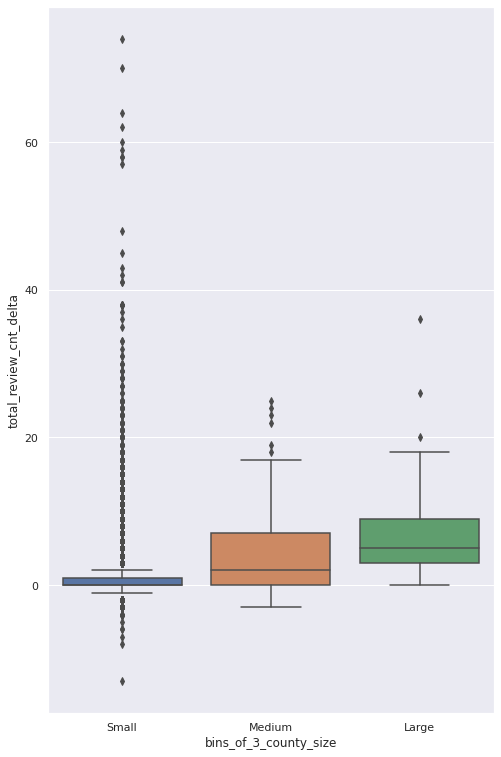

In [110]:
sns.set(rc={"figure.figsize":(8, 13)})
sns.boxplot(x='bins_of_3_county_size', y='total_review_cnt_delta', data=df3_w_bins)

KeyboardInterrupt: 

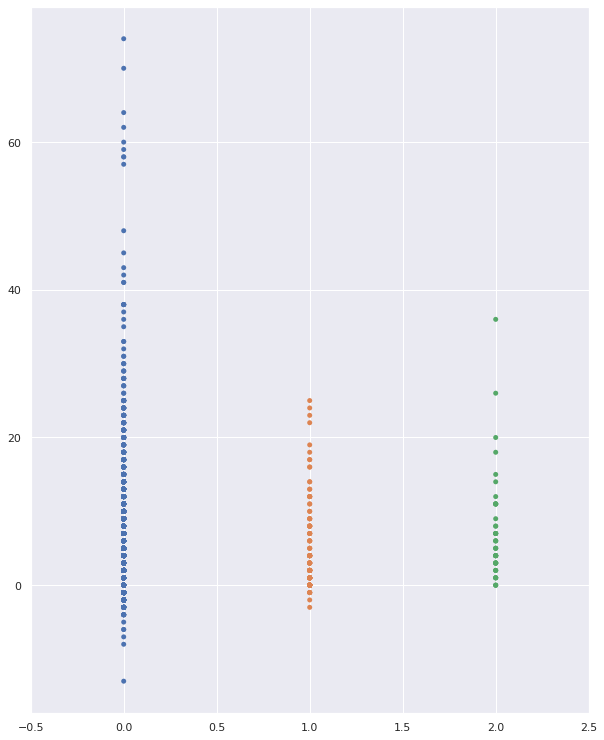

In [107]:
# sns.swarmplot(x='bins_of_3_mid_cat', y='total_review_cnt_delta', data=df3_w_bins)

Conditional summary statistics visualized also with the distribution shown through the violin plot

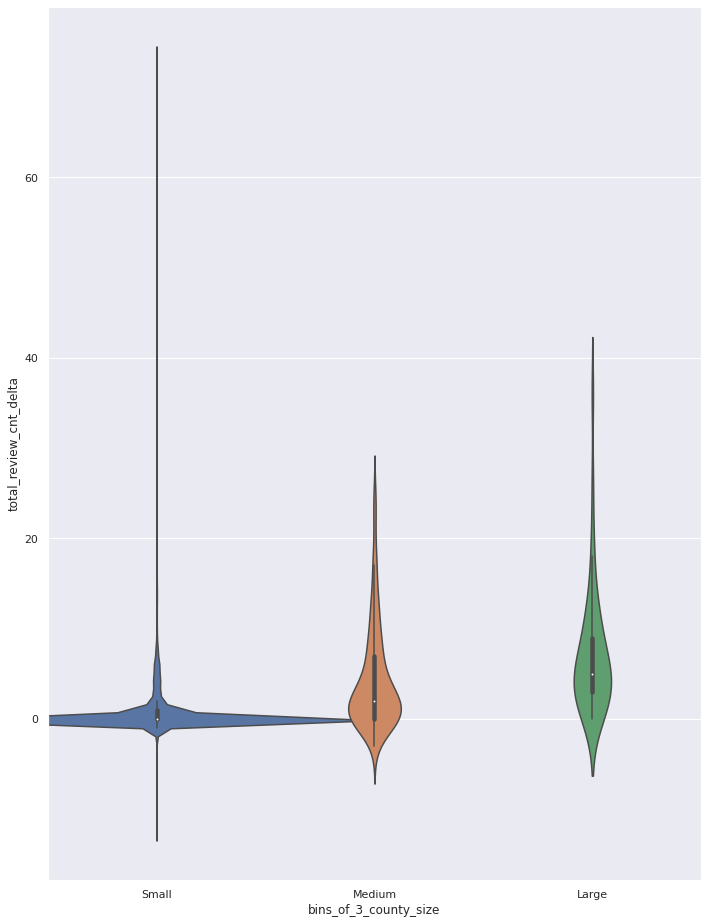

In [111]:
sns.set(rc={"figure.figsize":(10, 13)})
# sns.boxplot(x='bins_of_3_mid_cat', y='total_review_cnt_delta', data=df3_w_bins)
sns.violinplot(x='bins_of_3_county_size', y='total_review_cnt_delta', data=df3_w_bins, width=2) 
plt.tight_layout()
plt.show()

Conditional summary statistics for each county size category

In [115]:
def view_stats(x):
    stat_dict = {}
    stat_dict['min'] = x.min()
    stat_dict['qr1'] = x.quantile(.25)
    stat_dict['med'] = x.median()
    stat_dict['qr3'] = x.quantile(0.75)
    stat_dict['max'] = x.max()
    stat_dict['mean'] = x.mean()
    stat_dict['count']= x.count,x.shape
    return pd.Series(stat_dict)


In [116]:
df3_w_bins.groupby(['bins_of_3_county_size'])['total_review_cnt_delta'].apply(view_stats).unstack()

min    qr1    med    qr3     max   mean  \
bins_of_3_county_size                                                
Small                 -13.0000 0.0000 0.0000 1.0000 74.0000 0.7285   
Medium                 -3.0000 0.0000 2.0000 7.0000 25.0000 4.3649   
Large                   0.0000 3.0000 5.0000 9.0000 36.0000 7.0408   

                                                                   count  
bins_of_3_county_size                                                     
Small                  (<bound method Series.count of 0        0.0000...  
Medium                 (<bound method Series.count of 13387    4.0000...  
Large                  (<bound method Series.count of 18131    7.0000...

> Maybe try rating (y) on estimated pop. the idea being there will be all kinds of people with all kinds of likes. But this wouldn't be the weighted average since it won't take the review counts into account but it will help get a general idea

To begin bus_cat_dataframe and holding_dataframe will be merged to get some summary statistics 

In [56]:
# bus_cat_holding= bus_cat_dataframe.merge(right=holding_dataframe, how='inner', on = 'BusinessName')

In [57]:
# bus_cat_holding

Now we'll group by categoryname and check out some aggregates results

In [58]:
# cat_groups = bus_cat_holding.groupby(['BusinessCategoryName'], as_index=False)[['ReviewCount','BusinessRating']].agg({"ReviewCount": ['sum', 'mean', 'max'], "BusinessRating": ['mean', 'max']})
# cat_groups

Here we took a some of the review count which isn't the best statistic considering our data consists of review counts at the end of each data however it does give some insight into the most visited businesses.\
To make more sense of the data it would be best to sort on some columns

In [59]:
# cat_groups_Sorted = cat_groups.sort_values(by=[('ReviewCount', 'mean'), ('BusinessRating', 'mean'), ('ReviewCount', 'sum')], ascending=False)
# cat_groups_Sorted.head(10)

What's interesting is that these businesses seem to be very niche and don't seem that they would be frequented by a diverse range of visitors aside from the public markets \
We're going to modify our sort and see what happens

In [60]:
# cat_groups_Sorted = cat_groups.sort_values(by=[('ReviewCount', 'sum'), ('ReviewCount', 'mean'),  ('BusinessRating', 'mean')], ascending=False)
# cat_groups_Sorted.head(10)

Here we get a different picture but it could be perhaps misleading shown by the following business category counts

In [61]:
# bus_cat_holding.groupby(['BusinessCategoryName'], as_index=False)['BusinessName'].count().sort_values(by=[
#     'BusinessName'], ascending=False).head(10)